In [1]:
import joblib
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

from IPython.display import display

from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, f1_score
from sklearn.model_selection import train_test_split

import seaborn as sns

import sympy as sym
from sympy import Symbol, sympify, lambdify, abc, SympifyError

from gplearn.genetic import SymbolicClassifier
from sympy import *

import types

import graphviz

from sklearn.preprocessing import MinMaxScaler
from copy import deepcopy

sns.set_style("darkgrid")

In [2]:
np.random.seed(42)

## Utility Functions

In [3]:
def calculate_function_values_from_sympy(function, data_points, variable_names=None):
    function_vars = None
    
    if variable_names is None:
        variable_names = ['X' + str(i) for i in range(data_points.shape[1])]
    
    if function is None:
        return np.array([np.nan for i in range(data_points.shape[0])])
    try:
        if variable_names is None:
            function_vars = function.atoms(Symbol)
            print(function_vars)
        else:
            function_vars = [sym.symbols(variable_name, real=True) for variable_name in variable_names]
        #print('function_vars', function_vars)
        lambda_function = lambdify([function_vars], function, modules=["scipy", "numpy"])
        #print('lambda_function', lambda_function)
        #print('data_points[0]', data_points[0])
        if len(function_vars) >= 1:
            function_values = [lambda_function(data_point) for data_point in data_points]
            
        else:
            function_values = [lambda_function() for i in range(data_points.shape[0])]
    except (NameError, KeyError) as e:
        #print(e)
        function_values = []
        for data_point in data_points:
            function_value = function.evalf(subs={var: data_point[index] for index, var in enumerate(list(function_vars))})
            try:
                function_value = float(function_value)
            except TypeError as te:
                #print('te', te)
                #print('function_value', function_value)
                #print('function', function)
                #print('function_vars', function_vars, type(function_vars))
                function_value = np.inf
            function_values.append(function_value)
    function_values = np.nan_to_num(function_values).ravel()
                
    return function_values

In [4]:
def print_decision_tree_nodes(decision_tree): 
    
    n_nodes = decision_tree.tree_.node_count
    children_left = decision_tree.tree_.children_left
    children_right = decision_tree.tree_.children_right
    feature = decision_tree.tree_.feature
    threshold = decision_tree.tree_.threshold

    node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
    is_leaves = np.zeros(shape=n_nodes, dtype=bool)
    stack = [(0, 0)]  # start with the root node id (0) and its depth (0)
    while len(stack) > 0:
        # `pop` ensures each node is only visited once
        node_id, depth = stack.pop()
        node_depth[node_id] = depth

        # If the left and right child of a node is not the same we have a split
        # node
        is_split_node = children_left[node_id] != children_right[node_id]
        # If a split node, append left and right children and depth to `stack`
        # so we can loop through them
        if is_split_node:
            stack.append((children_left[node_id], depth + 1))
            stack.append((children_right[node_id], depth + 1))
        else:
            is_leaves[node_id] = True

    print("The binary tree structure has {n} nodes and has "
          "the following tree structure:\n".format(n=n_nodes))
    for i in range(n_nodes):
        if is_leaves[i]:
            print("{space}node={node} is a leaf node.".format(
                space=node_depth[i] * "\t", node=i))
        else:
            print("{space}node={node} is a split node: "
                  "go to node {left} if X[:, {feature}] <= {threshold} "
                  "else to node {right}.".format(
                      space=node_depth[i] * "\t",
                      node=i,
                      left=children_left[i],
                      feature=feature[i],
                      threshold=threshold[i],
                      right=children_right[i]))    

## Load Histograms and Data Statistics

In [5]:
with open("./data/summarizing_statistics.pkl", 'rb') as f:
    summarizing_statistics = joblib.load(f)

In [6]:
summarizing_statistics

number_of_datapoints energy_norm_log_mean temperature_diff_mean  \
on               9680213             1.861944              9.513191   
off             16775063            -3.226129              1.274514   
all             26455276            -1.364360              4.289117   

    rms_norm_log_mean details_ratedhead_mean energy_norm_log_min  \
on           0.730331             105.323685           -5.914482   
off         -1.542884              89.319163          -10.605203   
all         -0.711095              95.175355          -10.605203   

    temperature_diff_min rms_norm_log_min details_ratedhead_min  \
on               -24.000        -3.043901                  -1.0   
off              -38.875        -4.430309                  -1.0   
all              -38.875        -4.430309                  -1.0   

    energy_norm_log_max temperature_diff_max rms_norm_log_max  \
on             9.212087           110.625000         6.308744   
off            7.588837           109.140903         4.138240   
all            9.212087           110.625000         6.308744   

    details_ratedhead_max                                  Covariance_matrix  
on                 2403.0  [[4.054988675775044, 1.6181932043448362, 1.438...  
off                2403.0  [[1.5394827351582467, 0.21880415026212985, 0.7...  
all                2403.0  [[8.466562429846425, 10.45687699516861, 3.7031...

In [7]:
with open("./data/hist_on.pkl", 'rb') as f:
    hist_on = joblib.load(f)

In [8]:
with open("./data/hist_off.pkl", 'rb') as f:
    hist_off = joblib.load(f)

In [9]:
print('Total ON:',sum(hist_on.reshape(1,-1)[0]))

Total ON: 9639507


In [10]:
print('Total OFF:',sum(hist_off.reshape(1,-1)[0]))


Total OFF: 16741535


In [11]:
path = "./data/replica_summarizing_statistics.csv"
summarizing_statistics_replica = pd.read_csv(path, index_col=0)

In [12]:
summarizing_statistics_replica

number_of_datapoints  energy_norm_log_mean  \
on                        9680213              1.861944   
on_replica                9639507              2.262454   
off                      16775063             -3.226129   
off_replica              16741535             -2.791476   
all                      26455276             -1.364360   
all_replica              26381042             -0.944794   

             temperature_diff_mean  rms_norm_log_mean  details_ratedhead_mean  \
on                        9.513191           0.730331              105.323685   
on_replica               11.145556           0.925975              118.743587   
off                       1.274514          -1.542884               89.319163   
off_replica               4.517446          -1.396657              107.331233   
all                       4.289117          -0.711095               95.175355   
all_replica               6.939326          -0.547978              111.501253   

             energy_norm_log_min  temperature_diff_min  rms_norm_log_min  \
on                     -5.914482            -24.000000         -3.043901   
on_replica             -5.843427            -23.977141         -3.021036   
off                   -10.605203            -38.875000         -4.430309   
off_replica            -9.894227            -37.217121         -4.272182   
all                   -10.605203            -38.875000         -4.430309   
all_replica            -9.894227            -37.217121         -4.272182   

             details_ratedhead_min  energy_norm_log_max  temperature_diff_max  \
on                       -1.000000             9.212087            110.625000   
on_replica                0.000006            10.007755            117.621411   
off                      -1.000000             7.588837            109.140903   
off_replica               0.000004             8.534652            106.621120   
all                      -1.000000             9.212087            110.625000   
all_replica               0.000004            10.007755            117.621411   

             rms_norm_log_max  details_ratedhead_max  \
on                   6.308744            2403.000000   
on_replica           6.767623            2402.992395   
off                  4.138240            2403.000000   
off_replica          4.482172            2402.991829   
all                  6.308744            2403.000000   
all_replica          6.767623            2402.992395   

                                             Covariance_matrix  
on           [[4.05498868e+00 1.61819320e+00 1.43801350e+00...  
on_replica   [[ 4.60037788e+00  1.66251134e+00  1.59768757e...  
off          [[ 1.53948274e+00  2.18804150e-01  7.78027734e...  
off_replica  [[ 1.77712398e+00  9.46578975e-02  8.42137846e...  
all          [[8.46656243e+00 1.04568770e+01 3.70312553e+00...  
all_replica  [[8.73149553e+00 8.43511366e+00 3.84013568e+00...

In [13]:
path = "./data/replica_pump_data.csv"
pump_data_replica = pd.read_csv(path)
print(pump_data_replica.shape)

(26381042, 5)


In [14]:
with open("./data/randForestBest_20201002.pkl", 'rb') as f:
    random_forest_model = joblib.load(f)  

/home/smarton/anaconda3/envs/xai/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.23.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/home/smarton/anaconda3/envs/xai/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.23.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


# Insight into Dataframe

In [15]:
pump_data_replica.head()

energy_norm_log  temperature_diff  rms_norm_log  details_ratedhead  state
0        -4.642337         -0.585072     -2.831278          47.369469      1
1        -4.384410         -2.051363     -2.900545         120.240341      1
2        -5.047895          2.104730     -2.742720          92.577971      1
3        -4.962318          0.375291     -2.975236          75.714544      1
4        -5.082340         -1.878716     -2.900094          19.732252      1

In [16]:
pump_data_replica.describe()

energy_norm_log  temperature_diff  rms_norm_log  details_ratedhead  \
count     2.638104e+07      2.638104e+07  2.638104e+07       2.638104e+07   
mean     -9.447940e-01      6.939326e+00 -5.479782e-01       1.115013e+02   
std       2.954910e+00      9.601276e+00  1.405716e+00       1.955450e+02   
min      -9.894227e+00     -3.721712e+01 -4.272182e+00       4.127640e-06   
25%      -3.370405e+00      1.604177e+00 -1.820977e+00       3.802474e+01   
50%      -2.187935e+00      4.925814e+00 -9.364350e-01       7.603595e+01   
75%       1.350188e+00      8.836291e+00  5.890964e-01       1.140709e+02   
max       1.000776e+01      1.176214e+02  6.767623e+00       2.402992e+03   

              state  
count  2.638104e+07  
mean   3.653952e-01  
std    4.815408e-01  
min    0.000000e+00  
25%    0.000000e+00  
50%    0.000000e+00  
75%    1.000000e+00  
max    1.000000e+00

In [17]:
pump_data_replica.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26381042 entries, 0 to 26381041
Data columns (total 5 columns):
 #   Column             Dtype  
---  ------             -----  
 0   energy_norm_log    float64
 1   temperature_diff   float64
 2   rms_norm_log       float64
 3   details_ratedhead  float64
 4   state              int64  
dtypes: float64(4), int64(1)
memory usage: 1006.4 MB


In [18]:
legend_fontsize = 25
label_fontsize = 35
plot_fontsize = 30

figsize = (15, 9)
legend_loc = 2

color_1 = '#84b7e9'#'#c0d6ff'
color_2 = '#0a6fd3'#'#96bcff'
color_3 = '#06427e'#'#6ca1ff'


Text(0, 0.5, 'Frequency')

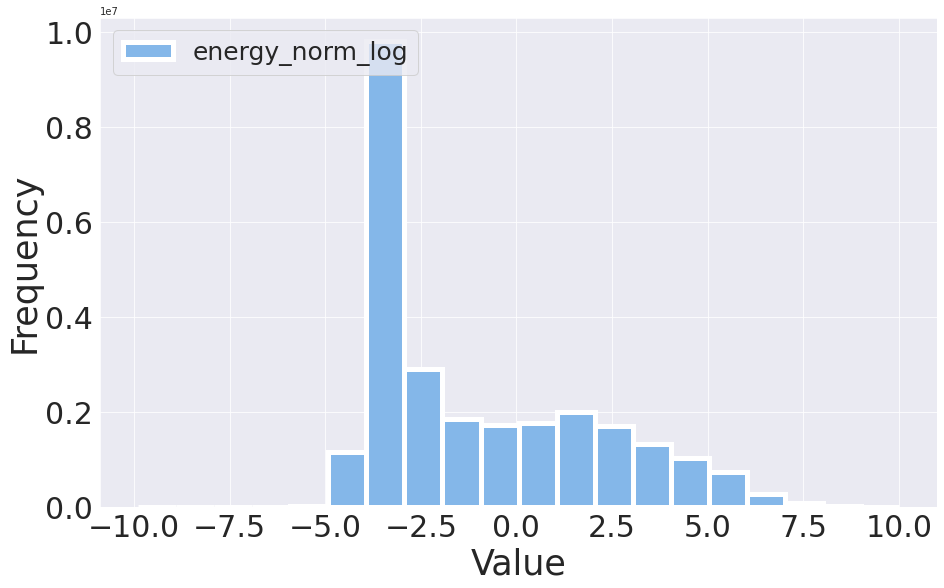

In [19]:
axes = pump_data_replica['energy_norm_log'].plot.hist(bins=20, 
                                               color=[color_1, color_2, color_3],
                                               #alpha=0.5,
                                               rot=0, 
                                               stacked=True,
                                               figsize=figsize, 
                                               fontsize=plot_fontsize, 
                                               linewidth=5)
#axes.ticklabel_format(useOffset=False, style='plain')
axes.legend(fontsize=legend_fontsize, loc = legend_loc) # loc=2
axes.set_xlabel('Value', fontsize=label_fontsize)
axes.set_ylabel('Frequency', fontsize=label_fontsize)

Text(0, 0.5, 'Frequency')

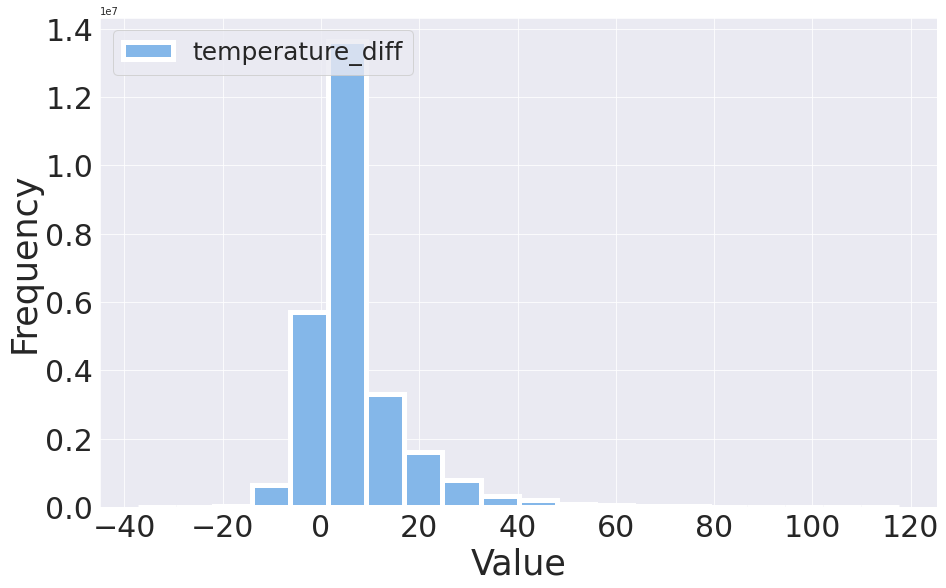

In [20]:
axes = pump_data_replica['temperature_diff'].plot.hist(bins=20, 
                                               color=[color_1, color_2, color_3],
                                               #alpha=0.5,
                                               rot=0, 
                                               stacked=True,
                                               figsize=figsize, 
                                               fontsize=plot_fontsize, 
                                               linewidth=5)
#axes.ticklabel_format(useOffset=False, style='plain')
axes.legend(fontsize=legend_fontsize, loc = legend_loc) # loc=2
axes.set_xlabel('Value', fontsize=label_fontsize)
axes.set_ylabel('Frequency', fontsize=label_fontsize)

Text(0, 0.5, 'Frequency')

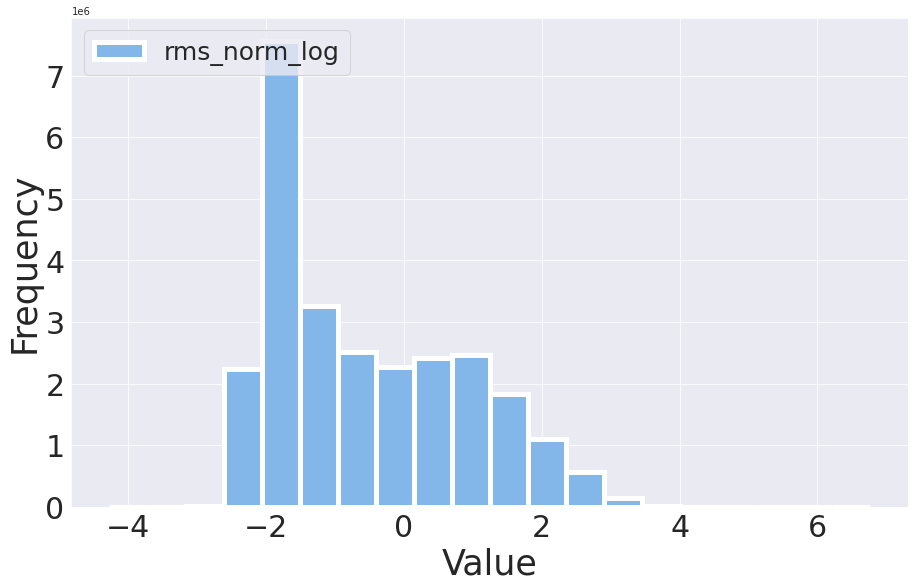

In [21]:
axes = pump_data_replica['rms_norm_log'].plot.hist(bins=20, 
                                               color=[color_1, color_2, color_3],
                                               #alpha=0.5,
                                               rot=0, 
                                               stacked=True,
                                               figsize=figsize, 
                                               fontsize=plot_fontsize, 
                                               linewidth=5)
#axes.ticklabel_format(useOffset=False, style='plain')
axes.legend(fontsize=legend_fontsize, loc = legend_loc) # loc=2
axes.set_xlabel('Value', fontsize=label_fontsize)
axes.set_ylabel('Frequency', fontsize=label_fontsize)

Text(0, 0.5, 'Frequency')

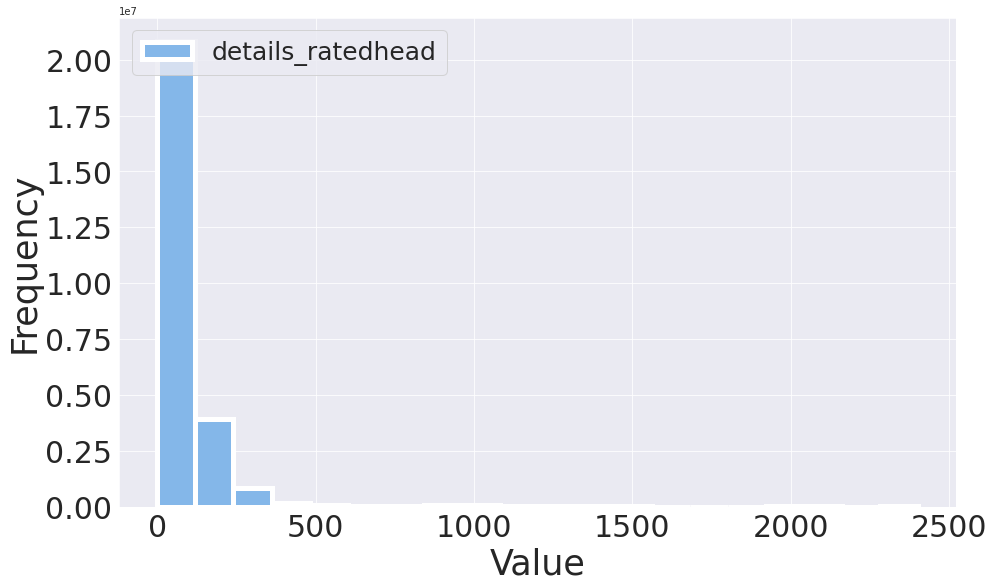

In [22]:
axes = pump_data_replica['details_ratedhead'].plot.hist(bins=20, 
                                               color=[color_1, color_2, color_3],
                                               #alpha=0.5,
                                               rot=0, 
                                               stacked=True,
                                               figsize=figsize, 
                                               fontsize=plot_fontsize, 
                                               linewidth=5)
#axes.ticklabel_format(useOffset=False, style='plain')
axes.legend(fontsize=legend_fontsize, loc = legend_loc) # loc=2
axes.set_xlabel('Value', fontsize=label_fontsize)
axes.set_ylabel('Frequency', fontsize=label_fontsize)

## Generate Data For Symbolic Metamodeling

In [23]:
pump_data_replica.head()

energy_norm_log  temperature_diff  rms_norm_log  details_ratedhead  state
0        -4.642337         -0.585072     -2.831278          47.369469      1
1        -4.384410         -2.051363     -2.900545         120.240341      1
2        -5.047895          2.104730     -2.742720          92.577971      1
3        -4.962318          0.375291     -2.975236          75.714544      1
4        -5.082340         -1.878716     -2.900094          19.732252      1

In [24]:
data = pump_data_replica.sample(n=10000)

X_data = data.drop(['state'], axis=1) #frac=0.1
y_data = data[['state']] #frac=0.1


In [25]:
X_data.head()

energy_norm_log  temperature_diff  rms_norm_log  details_ratedhead
13880350        -3.435427          2.008345     -1.831309          44.514913
13018525        -3.043470          4.328306     -2.011905          57.427111
22758968         0.059526          3.589398      0.421158          32.645146
26049008        -3.589604          2.368120     -2.103114         466.114163
4688620          0.485113          9.553305      1.172251          54.346425

In [26]:
y_data.head()

state
13880350      0
13018525      0
22758968      0
26049008      0
4688620       1

In [27]:
X_data.describe()

energy_norm_log  temperature_diff  rms_norm_log  details_ratedhead
count     10000.000000      10000.000000  10000.000000       10000.000000
mean         -0.903752          6.957620     -0.529029         108.840560
std           2.940251          9.583776      1.391853         179.754406
min          -5.676228        -22.095298     -2.981257           0.004160
25%          -3.347392          1.625078     -1.804050          38.281687
50%          -2.114641          4.917930     -0.892979          77.509069
75%           1.360277          8.790616      0.605675         114.241249
max           8.326624        108.964905      3.778478        2379.037789

In [28]:
X_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 13880350 to 9629643
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   energy_norm_log    10000 non-null  float64
 1   temperature_diff   10000 non-null  float64
 2   rms_norm_log       10000 non-null  float64
 3   details_ratedhead  10000 non-null  float64
dtypes: float64(4)
memory usage: 390.6 KB


# Symbolic Metamodeling

In [29]:
metamodeling_hyperparams = {
    'num_iter': 100,#500,
    'batch_size': 128,
    'learning_rate': 0.01,        
    'dataset_size': 5000,
    'exact_expression': True,
    'flat_function': False,
    'polynomial_degree': 3,
    'early_stopping': 50,
    'restarts': 10,
}

symbolic_classification_hyperparams = {     
    'dataset_size': 5000,
}

return_error = True

symbolic_metamodeling = False
symbolic_metamodeling_adjusted = True
symbolic_classification = True

In [30]:
accuracy_score(np.round(np.clip(data['energy_norm_log'].values * 1.631, 0, 1)).astype(int), data['state'].values)

0.9024

In [31]:
data = pump_data_replica.sample(n=metamodeling_hyperparams['dataset_size'])

data_scaled = np.empty_like(data.values.T[:-1])
scaler_list = []

for index, feature in enumerate(data.values.T[:-1]):
    
    scaler = MinMaxScaler(feature_range=(1e-4, 1))
    scaler.fit(feature.reshape(-1, 1))
    scaler_list.append(scaler)
    
    feature_scaled = scaler.transform(feature.reshape(-1, 1)).ravel()
    
    data_scaled[index] = feature_scaled
    
data_scaled = pd.DataFrame(data= data_scaled.T, index=data.index, columns=list(data.columns)[:-1])

In [32]:
data.head()

energy_norm_log  temperature_diff  rms_norm_log  details_ratedhead  \
3228774          0.722642          5.048562      0.478871         102.441835   
6648753          2.069493         24.442959      1.769626          66.284119   
25558960        -1.145248          4.071129     -0.063827         184.503801   
17578382        -3.199043          4.780609     -1.628835          27.827720   
4363318          1.854438          2.216334      0.973370          60.624418   

          state  
3228774       1  
6648753       1  
25558960      0  
17578382      0  
4363318       1

In [33]:
data_scaled.head()

energy_norm_log  temperature_diff  rms_norm_log  details_ratedhead
3228774          0.444761          0.210039      0.513313           0.042952
6648753          0.543485          0.410551      0.707789           0.027825
25558960         0.307845          0.199934      0.431546           0.077285
17578382         0.157302          0.207269      0.195749           0.011735
4363318          0.527721          0.180758      0.587818           0.025457

In [34]:
X_data = data.drop(['state'], axis=1).values #frac=0.1
y_data = data[['state']].values #frac=0.1

X_train_with_valid, X_test, y_train_with_valid, y_test = train_test_split(X_data, y_data, test_size=0.25, random_state=42)           
X_train, X_valid, y_train, y_valid= train_test_split(X_train_with_valid, y_train_with_valid, test_size=0.25, random_state=42)   


In [35]:
X_data_scaled = data_scaled.values 
X_train_with_valid_scaled, X_test_scaled = train_test_split(X_data_scaled, test_size=0.25, random_state=42)           
X_train_scaled, X_valid_scaled = train_test_split(X_train_with_valid_scaled, test_size=0.25, random_state=42)   

In [36]:
print(X_data.shape)
print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)
print()

print(y_data.shape)
print(y_train.shape)
print(y_valid.shape)
print(y_test.shape)

(5000, 4)
(2812, 4)
(938, 4)
(1250, 4)

(5000, 1)
(2812, 1)
(938, 1)
(1250, 1)


## Evaluate Model

In [37]:
y_test_random_forest = random_forest_model.predict(X_test)

accuracy_random_forest = accuracy_score(y_test, y_test_random_forest)

print('Accuracy: '+ str(accuracy_random_forest))


Accuracy: 0.904


In [38]:
if symbolic_metamodeling:
    from pysymbolic_original.algorithms.symbolic_metamodeling import symbolic_metamodel
    from pysymbolic_original.algorithms.symbolic_expressions import get_symbolic_model
    
    
    ## Symbolic Metamodeling
    if metamodeling_hyperparams['batch_size'] == None:
        metamodeling_hyperparams['batch_size'] = X_data.shape[0]

    metamodel = symbolic_metamodel(random_forest_model, 
                                   X_train, 
                                   mode="classification")

    metamodel.fit(num_iter=metamodeling_hyperparams['num_iter'], 
                  batch_size=metamodeling_hyperparams['batch_size'], 
                  learning_rate=metamodeling_hyperparams['learning_rate'])   


    if metamodeling_hyperparams['exact_expression']:
        metamodel_function = metamodel.exact_expression
        #print(metamodel_function)
    else:
        metamodel_function = metamodel.approx_expression
        #print(metamodel_function)


    y_test_metamodel = np.round(metamodel.evaluate(X_test)).astype(np.int64)
    y_test_model = random_forest_model.predict(X_test)

    accuracy_model_performance = accuracy_score(y_test, y_test_model)    
    accuracy_metamodel_performance = accuracy_score(y_test, y_test_metamodel) 

    accuracy_fidelity = accuracy_score(y_test_model, y_test_metamodel)     
    
    display(metamodel_function)
    
    print('Accuracy Random Forest Model:', accuracy_model_performance)
    print('Accuracy Symbolic Metaodel:', accuracy_metamodel_performance)
    
    print('Fidelity (Accuracy) Symbolic Metaodel - Random Forest Model:', accuracy_model_performance)

        


In [39]:
%load_ext autoreload 

In [40]:
if False:
    import pandas as pd
    from sklearn.preprocessing import MinMaxScaler
    from xgboost import XGBClassifier
    from sklearn.linear_model import LogisticRegression

    from sklearn.metrics import roc_auc_score
    from sklearn.model_selection import train_test_split


    data          = pd.read_csv("data/absenteeism.csv", delimiter=';')

    feature_names = ['Transportation expense', 'Distance from Residence to Work',
                     'Service time', 'Age', 'Work load Average/day ', 'Hit target',
                     'Disciplinary failure', 'Education', 'Son', 'Social drinker',
                     'Social smoker', 'Pet', 'Weight', 'Height', 'Body mass index']

    scaler        = MinMaxScaler(feature_range=(0, 1))
    X             = scaler.fit_transform(data[feature_names])
    Y             = ((data['Absenteeism time in hours'] > 4) * 1) 

    X_train_abse, X_test_abse, Y_train_abse, Y_test_abse = train_test_split(X, Y, test_size=0.33, random_state=42)

    model         = XGBClassifier()

    model.fit(X_train_abse, Y_train_abse)

In [41]:
random_forest_model_scaled = deepcopy(random_forest_model)

for dt in random_forest_model_scaled.estimators_:

    n_nodes = dt.tree_.node_count
    children_left = dt.tree_.children_left
    children_right = dt.tree_.children_right
    feature = dt.tree_.feature
    threshold = dt.tree_.threshold

    node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
    is_leaves = np.zeros(shape=n_nodes, dtype=bool)
    stack = [(0, 0)]  # start with the root node id (0) and its depth (0)
    while len(stack) > 0:
        # `pop` ensures each node is only visited once
        node_id, depth = stack.pop()
        node_depth[node_id] = depth

        # If the left and right child of a node is not the same we have a split
        # node
        is_split_node = children_left[node_id] != children_right[node_id]
        # If a split node, append left and right children and depth to `stack`
        # so we can loop through them
        if is_split_node:
            stack.append((children_left[node_id], depth + 1))
            stack.append((children_right[node_id], depth + 1))
        else:
            is_leaves[node_id] = True

    for i in range(n_nodes):
        if not is_leaves[i]:  
            threshold[i] = scaler_list[int(feature[i])].transform(np.array([threshold[i]]).reshape(1, -1)).ravel()[0]

In [42]:
#%autoreload 2
if symbolic_metamodeling_adjusted:
    from pysymbolic_adjusted.algorithms.symbolic_metamodeling import symbolic_metamodel
    from pysymbolic_adjusted.algorithms.symbolic_expressions import get_symbolic_model    
    
    ## Symbolic Metamodeling
    if metamodeling_hyperparams['batch_size'] == None:
        metamodeling_hyperparams['batch_size'] = X_train_scaled.shape[0]

    metamodel = symbolic_metamodel(random_forest_model_scaled, #random_forest_model, #model,#
                                   X_train_scaled, #X_train, #X_train_abse,#
                                   mode="classification", 
                                   approximation_order = metamodeling_hyperparams['polynomial_degree'], 
                                   force_polynomial=metamodeling_hyperparams['flat_function'],
                                   verbosity=True,
                                   early_stopping=metamodeling_hyperparams['early_stopping'],
                                   restarts=metamodeling_hyperparams['restarts'])

    metamodel.fit(num_iter=metamodeling_hyperparams['num_iter'], 
                  batch_size=metamodeling_hyperparams['batch_size'], 
                  learning_rate=metamodeling_hyperparams['learning_rate'])    

    if metamodeling_hyperparams['exact_expression']:
        metamodel_function = metamodel.exact_expression
        #print(metamodel_function)
    else:
        metamodel_function = metamodel.approx_expression
        #print(metamodel_function)

    y_test_metamodel_eval = np.round(metamodel.evaluate(X_test_scaled)).astype(np.int64)
    
    y_test_metamodel = np.round(np.clip(calculate_function_values_from_sympy(metamodel_function, X_test_scaled), 0, 1)).astype(np.int64).reshape(-1,1)#np.round(calculate_function_values_from_sympy(metamodel_function, X_test)).astype(np.int64)

    
    y_test_model = random_forest_model_scaled.predict(X_test_scaled)

    accuracy_model_performance = accuracy_score(y_test, y_test_model)    
    accuracy_metamodel_performance = accuracy_score(y_test, y_test_metamodel) 
    accuracy_metamodel_performance_eval = accuracy_score(y_test, y_test_metamodel_eval) 
    
    accuracy_fidelity = accuracy_score(y_test_model, y_test_metamodel)     
    accuracy_fidelity_eval = accuracy_score(y_test_model, y_test_metamodel_eval)   
    
    f1_model_performance = f1_score(y_test, y_test_model)    
    f1_metamodel_performance = f1_score(y_test, y_test_metamodel) 
    f1_metamodel_performance_eval = f1_score(y_test, y_test_metamodel_eval) 
    
    f1_fidelity = f1_score(y_test_model, y_test_metamodel)     
    f1_fidelity_eval = f1_score(y_test_model, y_test_metamodel_eval)      
    
    display(metamodel_function)
    
    print('Accuracy Random Forest Model:', accuracy_model_performance)
    print('Accuracy Symbolic Metaodel:', accuracy_metamodel_performance)
    print('Accuracy Symbolic Metaodel Eval:', accuracy_metamodel_performance_eval)
    
    print('Fidelity (Accuracy) Symbolic Metaodel - Random Forest Model:', accuracy_fidelity)
    print('Fidelity (Accuracy) Symbolic Metaodel Eval - Random Forest Model:', accuracy_fidelity_eval)
    
    print('F1 Score Random Forest Model:', f1_model_performance)
    print('F1 Score Symbolic Metaodel:', f1_metamodel_performance)
    print('F1 Score Symbolic Metaodel Eval:', f1_metamodel_performance_eval)
    
    print('Fidelity (F1 Score) Symbolic Metaodel - Random Forest Model:', f1_fidelity)
    print('Fidelity (F1 Score) Symbolic Metaodel Eval - Random Forest Model:', f1_fidelity_eval)

---- Tuning the basis functions ----


basis function loop:   0%|          | 0/4 [00:00<?, ?it/s]


restart loop:   0%|          | 0/11 [00:00<?, ?it/s]

iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 36.646
Iteration: 1 	--- Loss: 37.460
Iteration: 2 	--- Loss: 35.991
Iteration: 3 	--- Loss: 34.575
Iteration: 4 	--- Loss: 36.200
Iteration: 5 	--- Loss: 35.033
Iteration: 6 	--- Loss: 37.936
Iteration: 7 	--- Loss: 35.406
Iteration: 8 	--- Loss: 35.919
Iteration: 9 	--- Loss: 34.673
Iteration: 10 	--- Loss: 34.465
Iteration: 11 	--- Loss: 35.377
Iteration: 12 	--- Loss: 33.843
Iteration: 13 	--- Loss: 34.505
Iteration: 14 	--- Loss: 34.786
Iteration: 15 	--- Loss: 34.438
Iteration: 16 	--- Loss: 34.781
Iteration: 17 	--- Loss: 34.331
Iteration: 18 	--- Loss: 33.411
Iteration: 19 	--- Loss: 34.643
Iteration: 20 	--- Loss: 34.156
Iteration: 21 	--- Loss: 33.653
Iteration: 22 	--- Loss: 34.423
Iteration: 23 	--- Loss: 33.260
Iteration: 24 	--- Loss: 34.378
Iteration: 25 	--- Loss: 35.976
Iteration: 26 	--- Loss: 34.568
Iteration: 27 	--- Loss: 34.797
Iteration: 28 	--- Loss: 45.282
Iteration: 29 	--- Loss: 38.218
Iteration: 30 	--- Loss: 40.232
Iteration: 31 	---


restart loop:   9%|▉         | 1/11 [14:16<2:22:48, 856.86s/it]

Iteration: 163 	--- Loss: 31.369
Early Stopping requirement reached after 163 Iterations
New Global Minimum: 28.86798577714499


iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 34.725
Iteration: 1 	--- Loss: 36.133
Iteration: 2 	--- Loss: 35.901
Iteration: 3 	--- Loss: 35.853
Iteration: 4 	--- Loss: 38.133
Iteration: 5 	--- Loss: 35.082
Iteration: 6 	--- Loss: 36.298
Iteration: 7 	--- Loss: 36.652
Iteration: 8 	--- Loss: 37.266
Iteration: 9 	--- Loss: 40.804
Iteration: 10 	--- Loss: 37.150
Iteration: 11 	--- Loss: 38.459
Iteration: 12 	--- Loss: 40.134
Iteration: 13 	--- Loss: 37.367
Iteration: 14 	--- Loss: 37.286
Iteration: 15 	--- Loss: 36.994
Iteration: 16 	--- Loss: 38.906
Iteration: 17 	--- Loss: 36.097
Iteration: 18 	--- Loss: 37.793
Iteration: 19 	--- Loss: 36.248
Iteration: 20 	--- Loss: 36.291
Iteration: 21 	--- Loss: 33.466
Iteration: 22 	--- Loss: 36.919
Iteration: 23 	--- Loss: 38.651
Iteration: 24 	--- Loss: 35.066
Iteration: 25 	--- Loss: 35.672
Iteration: 26 	--- Loss: 35.317
Iteration: 27 	--- Loss: 34.383
Iteration: 28 	--- Loss: 32.540
Iteration: 29 	--- Loss: 32.755
Iteration: 30 	--- Loss: 35.135
Iteration: 31 	---


restart loop:  18%|█▊        | 2/11 [21:38<1:31:53, 612.57s/it]

Iteration: 94 	--- Loss: 35.514
Early Stopping requirement reached after 94 Iterations


iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 38.600
Iteration: 1 	--- Loss: 35.991
Iteration: 2 	--- Loss: 35.440
Iteration: 3 	--- Loss: 35.269
Iteration: 4 	--- Loss: 40.013
Iteration: 5 	--- Loss: 39.850
Iteration: 6 	--- Loss: 35.184
Iteration: 7 	--- Loss: 37.360
Iteration: 8 	--- Loss: 35.803
Iteration: 9 	--- Loss: 35.356
Iteration: 10 	--- Loss: 35.823
Iteration: 11 	--- Loss: 38.391
Iteration: 12 	--- Loss: 34.929
Iteration: 13 	--- Loss: 37.459
Iteration: 14 	--- Loss: 37.579
Iteration: 15 	--- Loss: 37.053
Iteration: 16 	--- Loss: 36.338
Iteration: 17 	--- Loss: 38.298
Iteration: 18 	--- Loss: 35.464
Iteration: 19 	--- Loss: 36.269
Iteration: 20 	--- Loss: 35.595
Iteration: 21 	--- Loss: 37.806
Iteration: 22 	--- Loss: 37.401
Iteration: 23 	--- Loss: 38.330
Iteration: 24 	--- Loss: 35.985
Iteration: 25 	--- Loss: 36.105
Iteration: 26 	--- Loss: 36.776
Iteration: 27 	--- Loss: 37.035
Iteration: 28 	--- Loss: 39.787
Iteration: 29 	--- Loss: 36.682
Iteration: 30 	--- Loss: 36.224
Iteration: 31 	---


restart loop:  27%|██▋       | 3/11 [24:06<53:25, 400.65s/it]  

te can't convert complex to float
function_value 1.03683536908882e-14 - 1.91787861614235e-14*I
function 4.18432570381539e-12*x**3.65776*exp(3.65776*I*pi)*hyper((1.0, 1.0), (5.22409,), 0.00202912325039506*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value 1.38082980132937e-13 - 2.5541797931035e-13*I
function 4.18432570381539e-12*x**3.65776*exp(3.65776*I*pi)*hyper((1.0, 1.0), (5.22409,), 0.00202912325039506*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value 8.88624152018096e-16 - 1.64372600487275e-15*I
function 4.18432570381539e-12*x**3.65776*exp(3.65776*I*pi)*hyper((1.0, 1.0), (5.22409,), 0.00202912325039506*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value 3.47861514008872e-14 - 6.43454283087214e-14*I
function 4.18432570381539e-12*x**3.65776*exp(3.65776*I*pi)*hyper((1.0, 1.0), (5.22409,), 0.00202912325039506*x*exp_polar(2*I*pi))
fu

iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 40.323
Iteration: 1 	--- Loss: 37.518
Iteration: 2 	--- Loss: 38.651
Iteration: 3 	--- Loss: 38.165
Iteration: 4 	--- Loss: 36.798
Iteration: 5 	--- Loss: 39.767
Iteration: 6 	--- Loss: 36.241
Iteration: 7 	--- Loss: 36.718
Iteration: 8 	--- Loss: 36.903
Iteration: 9 	--- Loss: 36.560
Iteration: 10 	--- Loss: 37.507
Iteration: 11 	--- Loss: 37.252
Iteration: 12 	--- Loss: 37.352
Iteration: 13 	--- Loss: 38.220
Iteration: 14 	--- Loss: 36.476
Iteration: 15 	--- Loss: 39.491
Iteration: 16 	--- Loss: 36.912
Iteration: 17 	--- Loss: 36.276
Iteration: 18 	--- Loss: 38.420
Iteration: 19 	--- Loss: 35.819
Iteration: 20 	--- Loss: 36.587
Iteration: 21 	--- Loss: 36.820
Iteration: 22 	--- Loss: 36.686
Iteration: 23 	--- Loss: 38.158
Iteration: 24 	--- Loss: 40.030
Iteration: 25 	--- Loss: 36.536
Iteration: 26 	--- Loss: 36.484
Iteration: 27 	--- Loss: 37.991
Iteration: 28 	--- Loss: 37.296
Iteration: 29 	--- Loss: 37.303
Iteration: 30 	--- Loss: 35.873
Iteration: 31 	---


restart loop:  36%|███▋      | 4/11 [32:06<50:23, 431.98s/it]

Iteration: 114 	--- Loss: 37.315
Early Stopping requirement reached after 114 Iterations


iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 35.392
Iteration: 1 	--- Loss: 35.265
Iteration: 2 	--- Loss: 37.132
Iteration: 3 	--- Loss: 36.295
Iteration: 4 	--- Loss: 37.642
Iteration: 5 	--- Loss: 37.615
Iteration: 6 	--- Loss: 39.099
Iteration: 7 	--- Loss: 38.383
Iteration: 8 	--- Loss: 36.147
Iteration: 9 	--- Loss: 40.451
Iteration: 10 	--- Loss: 38.801
Iteration: 11 	--- Loss: 38.260
Iteration: 12 	--- Loss: 36.072
Iteration: 13 	--- Loss: 38.491
Iteration: 14 	--- Loss: 35.640
Iteration: 15 	--- Loss: 37.380
Iteration: 16 	--- Loss: 35.215
Iteration: 17 	--- Loss: 36.430
Iteration: 18 	--- Loss: 35.562
Iteration: 19 	--- Loss: 35.032
Iteration: 20 	--- Loss: 36.761
Iteration: 21 	--- Loss: 37.208
Iteration: 22 	--- Loss: 37.662
Iteration: 23 	--- Loss: 38.728
Iteration: 24 	--- Loss: 34.801
Iteration: 25 	--- Loss: 38.313
Iteration: 26 	--- Loss: 36.708
Iteration: 27 	--- Loss: 34.526
Iteration: 28 	--- Loss: 35.967
Iteration: 29 	--- Loss: 35.449
Iteration: 30 	--- Loss: 32.233
Iteration: 31 	---


restart loop:  45%|████▌     | 5/11 [41:29<47:54, 479.14s/it]

Iteration: 125 	--- Loss: 37.690
Early Stopping requirement reached after 125 Iterations
New Global Minimum: 21.332666089664162


iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 38.017
Iteration: 1 	--- Loss: 39.229
Iteration: 2 	--- Loss: 36.277
Iteration: 3 	--- Loss: 35.941
Iteration: 4 	--- Loss: 37.551
Iteration: 5 	--- Loss: 39.010
Iteration: 6 	--- Loss: 39.232
Iteration: 7 	--- Loss: 37.962
Iteration: 8 	--- Loss: 39.479
Iteration: 9 	--- Loss: 35.481
Iteration: 10 	--- Loss: 37.417
Iteration: 11 	--- Loss: 39.084
Iteration: 12 	--- Loss: 38.317
Iteration: 13 	--- Loss: 37.700
Wrong c Value: -0.045522224
te can't convert complex to float
function_value 1.64780184155078e-9 - 6.7582598682194e-9*I
function 1.03751102041214e-6*x**3.57613*exp(3.57613*I*pi)*hyper((1.0, 1.0), (4.69558,), 0.0455222241580486*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value 2.98949753858439e-10 - 1.22610624237083e-9*I
function 1.03751102041214e-6*x**3.57613*exp(3.57613*I*pi)*hyper((1.0, 1.0), (4.69558,), 0.0455222241580486*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex t


restart loop:  55%|█████▍    | 6/11 [42:33<28:09, 337.96s/it]

te can't convert complex to float
function_value 9.40091269293562e-11 - 3.85567058946288e-10*I
function 1.03751102041214e-6*x**3.57613*exp(3.57613*I*pi)*hyper((1.0, 1.0), (4.69558,), 0.0455222241580486*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value 2.60571685260505e-8 - 1.06870323778316e-7*I
function 1.03751102041214e-6*x**3.57613*exp(3.57613*I*pi)*hyper((1.0, 1.0), (4.69558,), 0.0455222241580486*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value 3.27931259966129e-8 - 1.34497038289383e-7*I
function 1.03751102041214e-6*x**3.57613*exp(3.57613*I*pi)*hyper((1.0, 1.0), (4.69558,), 0.0455222241580486*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value 2.39619158274558e-10 - 9.82768983617228e-10*I
function 1.03751102041214e-6*x**3.57613*exp(3.57613*I*pi)*hyper((1.0, 1.0), (4.69558,), 0.0455222241580486*x*exp_polar(2*I*pi))
function_vars

iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 36.248
Iteration: 1 	--- Loss: 37.866
Iteration: 2 	--- Loss: 37.684
Iteration: 3 	--- Loss: 38.480
Iteration: 4 	--- Loss: 37.576
Iteration: 5 	--- Loss: 35.899
Iteration: 6 	--- Loss: 38.162
Iteration: 7 	--- Loss: 35.966
Iteration: 8 	--- Loss: 36.577
Iteration: 9 	--- Loss: 37.767
Iteration: 10 	--- Loss: 36.268
Iteration: 11 	--- Loss: 36.997
Iteration: 12 	--- Loss: 37.910
Iteration: 13 	--- Loss: 36.616
Iteration: 14 	--- Loss: 36.866
Iteration: 15 	--- Loss: 38.118
Iteration: 16 	--- Loss: 37.717
Iteration: 17 	--- Loss: 36.554
Iteration: 18 	--- Loss: 37.916
Iteration: 19 	--- Loss: 37.242
Iteration: 20 	--- Loss: 39.478
Iteration: 21 	--- Loss: 37.100
Iteration: 22 	--- Loss: 38.600
Iteration: 23 	--- Loss: 37.672
Iteration: 24 	--- Loss: 36.902
Iteration: 25 	--- Loss: 39.075
Iteration: 26 	--- Loss: 37.014
Iteration: 27 	--- Loss: 35.898
Iteration: 28 	--- Loss: 37.068
Iteration: 29 	--- Loss: 36.515
Iteration: 30 	--- Loss: 39.389
Iteration: 31 	---


restart loop:  64%|██████▎   | 7/11 [53:51<29:56, 449.08s/it]

Iteration: 156 	--- Loss: 36.691
Early Stopping requirement reached after 156 Iterations


iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 35.701
Iteration: 1 	--- Loss: 34.736
Iteration: 2 	--- Loss: 35.849
Iteration: 3 	--- Loss: 37.283
Iteration: 4 	--- Loss: 36.372
Iteration: 5 	--- Loss: 35.493
Iteration: 6 	--- Loss: 34.422
Iteration: 7 	--- Loss: 37.846
Iteration: 8 	--- Loss: 39.612
Iteration: 9 	--- Loss: 35.878
Iteration: 10 	--- Loss: 39.044
Iteration: 11 	--- Loss: 37.852
Iteration: 12 	--- Loss: 40.311
Iteration: 13 	--- Loss: 37.335
Iteration: 14 	--- Loss: 37.485
Iteration: 15 	--- Loss: 37.382
Iteration: 16 	--- Loss: 36.491
Iteration: 17 	--- Loss: 37.151
Wrong c Value: -0.0069975257
te can't convert complex to float
function_value 1.54274399954425e-13 + 6.66746950473817e-14*I
function 1.49517373229389e-11*x**4.12985*exp(4.12985*I*pi)*hyper((1.0, 1.0), (5.78988,), 0.00699752569198608*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value 2.30292933411511e-12 + 9.95285744836181e-13*I
function 1.49517373229389e-11*x**4.12985*exp(4.12985


restart loop:  73%|███████▎  | 8/11 [55:11<16:35, 331.74s/it]

te can't convert complex to float
function_value 2.72735632065247e-12 + 1.17871565871443e-12*I
function 1.49517373229389e-11*x**4.12985*exp(4.12985*I*pi)*hyper((1.0, 1.0), (5.78988,), 0.00699752569198608*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value 3.8907638600223e-16 + 1.68152003148284e-16*I
function 1.49517373229389e-11*x**4.12985*exp(4.12985*I*pi)*hyper((1.0, 1.0), (5.78988,), 0.00699752569198608*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value 4.80749295886046e-12 + 2.07771430042281e-12*I
function 1.49517373229389e-11*x**4.12985*exp(4.12985*I*pi)*hyper((1.0, 1.0), (5.78988,), 0.00699752569198608*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value 3.67428228539154e-13 + 1.58796048449289e-13*I
function 1.49517373229389e-11*x**4.12985*exp(4.12985*I*pi)*hyper((1.0, 1.0), (5.78988,), 0.00699752569198608*x*exp_polar(2*I*pi))
fu

iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 37.008
Iteration: 1 	--- Loss: 36.155
Iteration: 2 	--- Loss: 34.684
Iteration: 3 	--- Loss: 37.508
Iteration: 4 	--- Loss: 35.364
Iteration: 5 	--- Loss: 34.764
Iteration: 6 	--- Loss: 37.796
Iteration: 7 	--- Loss: 37.789
Iteration: 8 	--- Loss: 36.817
Iteration: 9 	--- Loss: 36.985
Iteration: 10 	--- Loss: 37.124
Iteration: 11 	--- Loss: 39.699
Wrong c Value: -0.054963708
te can't convert complex to float
function_value -4.30911670329979e-9 - 1.14230188675307e-8*I
function 2.42806093888994e-6*x**3.38518*exp(3.38518*I*pi)*hyper((1.0, 1.0), (4.95315,), 0.0549637079238892*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -9.45122903700353e-10 - 2.50542222558909e-9*I
function 2.42806093888994e-6*x**3.38518*exp(3.38518*I*pi)*hyper((1.0, 1.0), (4.95315,), 0.0549637079238892*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -1.12186924779781e-9 - 2.9739583461926

te can't convert complex to float
function_value -1.62412977615557e-7 - 4.30539861269863e-7*I
function 2.42806093888994e-6*x**3.38518*exp(3.38518*I*pi)*hyper((1.0, 1.0), (4.95315,), 0.0549637079238892*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -1.0302756557025e-9 - 2.73115328829107e-9*I
function 2.42806093888994e-6*x**3.38518*exp(3.38518*I*pi)*hyper((1.0, 1.0), (4.95315,), 0.0549637079238892*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -1.49749484671305e-9 - 3.96970262488688e-9*I
function 2.42806093888994e-6*x**3.38518*exp(3.38518*I*pi)*hyper((1.0, 1.0), (4.95315,), 0.0549637079238892*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -4.65133926596772e-7 - 1.23302151816284e-6*I
function 2.42806093888994e-6*x**3.38518*exp(3.38518*I*pi)*hyper((1.0, 1.0), (4.95315,), 0.0549637079238892*x*exp_polar(2*I*pi))
function_vars 

restart loop:  82%|████████▏ | 9/11 [56:07<08:10, 245.34s/it]

iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 36.203
Iteration: 1 	--- Loss: 37.563
Iteration: 2 	--- Loss: 34.628
Iteration: 3 	--- Loss: 36.046
Iteration: 4 	--- Loss: 36.321
Iteration: 5 	--- Loss: 37.211
Iteration: 6 	--- Loss: 36.550
Iteration: 7 	--- Loss: 37.540
Iteration: 8 	--- Loss: 38.002
Iteration: 9 	--- Loss: 37.396
Iteration: 10 	--- Loss: 37.499
Iteration: 11 	--- Loss: 39.286
Iteration: 12 	--- Loss: 36.014
Iteration: 13 	--- Loss: 36.079
Iteration: 14 	--- Loss: 37.481
Iteration: 15 	--- Loss: 37.009
Iteration: 16 	--- Loss: 41.505
Iteration: 17 	--- Loss: 36.859
Iteration: 18 	--- Loss: 38.863
Iteration: 19 	--- Loss: 39.128
Iteration: 20 	--- Loss: 36.855
Iteration: 21 	--- Loss: 35.740
Iteration: 22 	--- Loss: 36.663
Iteration: 23 	--- Loss: 39.793
Iteration: 24 	--- Loss: 38.425
Iteration: 25 	--- Loss: 40.249
Iteration: 26 	--- Loss: 34.788
Iteration: 27 	--- Loss: 36.343
Iteration: 28 	--- Loss: 37.462
Iteration: 29 	--- Loss: 37.969
Iteration: 30 	--- Loss: 37.051
Iteration: 31 	---


restart loop:  91%|█████████ | 10/11 [59:45<03:56, 236.99s/it]

Iteration: 53 	--- Loss: 36.626
Early Stopping requirement reached after 53 Iterations


iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 38.365
Iteration: 1 	--- Loss: 37.410
Iteration: 2 	--- Loss: 36.796
Iteration: 3 	--- Loss: 38.079
Iteration: 4 	--- Loss: 36.592
Iteration: 5 	--- Loss: 35.833
Iteration: 6 	--- Loss: 37.150
Iteration: 7 	--- Loss: 37.664
Iteration: 8 	--- Loss: 35.285
Iteration: 9 	--- Loss: 34.724
Iteration: 10 	--- Loss: 38.107
Iteration: 11 	--- Loss: 37.269
Iteration: 12 	--- Loss: 37.522
Iteration: 13 	--- Loss: 37.895
Iteration: 14 	--- Loss: 37.028
Iteration: 15 	--- Loss: 37.380
Iteration: 16 	--- Loss: 36.246
Iteration: 17 	--- Loss: 38.798
Iteration: 18 	--- Loss: 38.703
Iteration: 19 	--- Loss: 36.882
Iteration: 20 	--- Loss: 37.203
Iteration: 21 	--- Loss: 37.156
Iteration: 22 	--- Loss: 36.458
Iteration: 23 	--- Loss: 37.680
Iteration: 24 	--- Loss: 36.538
Wrong c Value: -0.002732275
te can't convert complex to float
function_value 1.99094369869218e-16 - 8.35497556609131e-18*I
function 5.44291967362134e-13*x**3.98665*exp(3.98665*I*pi)*hyper((1.0, 1.0), (5.95306,)


restart loop: 100%|██████████| 11/11 [1:01:34<00:00, 335.88s/it]

restart loop:   0%|          | 0/11 [00:00<?, ?it/s]

te can't convert complex to float
function_value 4.17810226204936e-15 - 1.75333648736445e-16*I
function 5.44291967362134e-13*x**3.98665*exp(3.98665*I*pi)*hyper((1.0, 1.0), (5.95306,), 0.00273227505385876*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value 8.72728838271037e-14 - 3.66239794945861e-15*I
function 5.44291967362134e-13*x**3.98665*exp(3.98665*I*pi)*hyper((1.0, 1.0), (5.95306,), 0.00273227505385876*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value 2.64153296463075e-13 - 1.10851669944319e-14*I
function 5.44291967362134e-13*x**3.98665*exp(3.98665*I*pi)*hyper((1.0, 1.0), (5.95306,), 0.00273227505385876*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value 2.1036319120662e-16 - 8.82787054044188e-18*I
function 5.44291967362134e-13*x**3.98665*exp(3.98665*I*pi)*hyper((1.0, 1.0), (5.95306,), 0.00273227505385876*x*exp_polar(2*I*pi))
fu

iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 37.945
Iteration: 1 	--- Loss: 40.061
Iteration: 2 	--- Loss: 39.446
Iteration: 3 	--- Loss: 37.883
Iteration: 4 	--- Loss: 37.416
Iteration: 5 	--- Loss: 38.226
Iteration: 6 	--- Loss: 36.582
Iteration: 7 	--- Loss: 36.199
Iteration: 8 	--- Loss: 37.018
Iteration: 9 	--- Loss: 38.286
Iteration: 10 	--- Loss: 39.145
Iteration: 11 	--- Loss: 36.885
Iteration: 12 	--- Loss: 36.354
Iteration: 13 	--- Loss: 37.750
Iteration: 14 	--- Loss: 36.862
Iteration: 15 	--- Loss: 38.641
Iteration: 16 	--- Loss: 37.220
Iteration: 17 	--- Loss: 36.529
Iteration: 18 	--- Loss: 35.848
Iteration: 19 	--- Loss: 36.081
Iteration: 20 	--- Loss: 37.321
Iteration: 21 	--- Loss: 39.821
Iteration: 22 	--- Loss: 37.101
Iteration: 23 	--- Loss: 37.170
Iteration: 24 	--- Loss: 35.891
Iteration: 25 	--- Loss: 36.064
Iteration: 26 	--- Loss: 38.146
Iteration: 27 	--- Loss: 37.213
Iteration: 28 	--- Loss: 40.053
Iteration: 29 	--- Loss: 38.790
Iteration: 30 	--- Loss: 37.941
Iteration: 31 	---


restart loop:   9%|▉         | 1/11 [05:45<57:39, 345.97s/it]

Iteration: 85 	--- Loss: 37.677
Early Stopping requirement reached after 85 Iterations
New Global Minimum: 33.003878084290854


iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 35.212
Iteration: 1 	--- Loss: 35.878
Iteration: 2 	--- Loss: 38.271
Iteration: 3 	--- Loss: 37.086
Iteration: 4 	--- Loss: 38.351
Iteration: 5 	--- Loss: 38.257
Iteration: 6 	--- Loss: 37.406
Iteration: 7 	--- Loss: 35.688
Iteration: 8 	--- Loss: 36.202
Iteration: 9 	--- Loss: 37.020
Iteration: 10 	--- Loss: 35.713
Iteration: 11 	--- Loss: 35.034
Iteration: 12 	--- Loss: 37.041
Iteration: 13 	--- Loss: 38.840
Iteration: 14 	--- Loss: 36.093
Iteration: 15 	--- Loss: 37.783
Iteration: 16 	--- Loss: 37.233
Iteration: 17 	--- Loss: 38.107
Iteration: 18 	--- Loss: 34.705
Iteration: 19 	--- Loss: 38.047
Iteration: 20 	--- Loss: 38.326
Iteration: 21 	--- Loss: 37.329
Iteration: 22 	--- Loss: 37.130
Iteration: 23 	--- Loss: 34.347
Iteration: 24 	--- Loss: 38.327
Iteration: 25 	--- Loss: 37.127
Iteration: 26 	--- Loss: 39.305
Iteration: 27 	--- Loss: 38.240
Iteration: 28 	--- Loss: 39.377
Iteration: 29 	--- Loss: 39.130
Iteration: 30 	--- Loss: 38.955
Iteration: 31 	---


restart loop:  18%|█▊        | 2/11 [10:50<48:14, 321.57s/it]

Iteration: 74 	--- Loss: 35.724
Early Stopping requirement reached after 74 Iterations


iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 37.187
Iteration: 1 	--- Loss: 38.567
Iteration: 2 	--- Loss: 36.096
Iteration: 3 	--- Loss: 35.559
Iteration: 4 	--- Loss: 36.924
Iteration: 5 	--- Loss: 39.771
Iteration: 6 	--- Loss: 36.573
Iteration: 7 	--- Loss: 38.487
Iteration: 8 	--- Loss: 37.290
Iteration: 9 	--- Loss: 36.960
Iteration: 10 	--- Loss: 36.355
Iteration: 11 	--- Loss: 35.133
Iteration: 12 	--- Loss: 36.970
Iteration: 13 	--- Loss: 33.904
Iteration: 14 	--- Loss: 28.274
Iteration: 15 	--- Loss: 30.597
Iteration: 16 	--- Loss: 30.491
Iteration: 17 	--- Loss: 29.090
Iteration: 18 	--- Loss: 32.941
Iteration: 19 	--- Loss: 32.921
Iteration: 20 	--- Loss: 34.507
Iteration: 21 	--- Loss: 35.325
Iteration: 22 	--- Loss: 34.549
Iteration: 23 	--- Loss: 36.312
Iteration: 24 	--- Loss: 34.807
Iteration: 25 	--- Loss: 33.873
Iteration: 26 	--- Loss: 35.451
Iteration: 27 	--- Loss: 34.391
Iteration: 28 	--- Loss: 35.172
Iteration: 29 	--- Loss: 34.307
Iteration: 30 	--- Loss: 35.951
Iteration: 31 	---


restart loop:  27%|██▋       | 3/11 [18:31<51:21, 385.22s/it]

Iteration: 111 	--- Loss: 35.515
Early Stopping requirement reached after 111 Iterations
New Global Minimum: 26.834378607563764


iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 35.307
Iteration: 1 	--- Loss: 35.795
Iteration: 2 	--- Loss: 35.440
Iteration: 3 	--- Loss: 36.675
Iteration: 4 	--- Loss: 36.917
Iteration: 5 	--- Loss: 34.078
Iteration: 6 	--- Loss: 35.996
Iteration: 7 	--- Loss: 36.501
Iteration: 8 	--- Loss: 35.253
Iteration: 9 	--- Loss: 38.204
Iteration: 10 	--- Loss: 36.460
Wrong c Value: -0.0055481344
te can't convert complex to float
function_value 7.48086130406052e-13 - 6.36215077958063e-13*I
function 5.56863308752532e-10*x**3.77567*exp(3.77567*I*pi)*hyper((1.0, 1.0), (3.92372,), 0.0055481344461441*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value 1.3246392092838e-12 - 1.12654867340391e-12*I
function 5.56863308752532e-10*x**3.77567*exp(3.77567*I*pi)*hyper((1.0, 1.0), (3.92372,), 0.0055481344461441*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value 1.8820412445288e-12 - 1.60059512994614e-12*I
function 5.56863308752


restart loop:  36%|███▋      | 4/11 [19:22<29:33, 253.30s/it]


function_vars [x] <class 'list'>
te can't convert complex to float
function_value 1.18868572021473e-12 - 1.01092607844977e-12*I
function 5.56863308752532e-10*x**3.77567*exp(3.77567*I*pi)*hyper((1.0, 1.0), (3.92372,), 0.0055481344461441*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value 9.72781450219393e-12 - 8.27308783082984e-12*I
function 5.56863308752532e-10*x**3.77567*exp(3.77567*I*pi)*hyper((1.0, 1.0), (3.92372,), 0.0055481344461441*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value 1.62158156516742e-12 - 1.37908537528742e-12*I
function 5.56863308752532e-10*x**3.77567*exp(3.77567*I*pi)*hyper((1.0, 1.0), (3.92372,), 0.0055481344461441*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value 9.6388917838051e-13 - 8.19746288349752e-13*I
function 5.56863308752532e-10*x**3.77567*exp(3.77567*I*pi)*hyper((1.0, 1.0), (3.92372,), 0.0055481344

iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 37.041
Iteration: 1 	--- Loss: 40.197
Iteration: 2 	--- Loss: 38.173
Iteration: 3 	--- Loss: 36.969
Iteration: 4 	--- Loss: 38.425
Iteration: 5 	--- Loss: 39.932
Iteration: 6 	--- Loss: 39.800
Iteration: 7 	--- Loss: 35.480
Wrong c Value: -0.017203897
te can't convert complex to float
function_value 2.00666955720208e-11 - 2.55435311554901e-10*I
function 6.7895156600335e-7*x**3.52495*exp(3.52495*I*pi)*hyper((1.0, 1.0), (1.3759,), 0.0172038972377777*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value 2.955003494025e-11 - 3.76151736310058e-10*I
function 6.7895156600335e-7*x**3.52495*exp(3.52495*I*pi)*hyper((1.0, 1.0), (1.3759,), 0.0172038972377777*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value 3.61000649501999e-10 - 4.59529138946212e-9*I
function 6.7895156600335e-7*x**3.52495*exp(3.52495*I*pi)*hyper((1.0, 1.0), (1.3759,), 0.0172038972377777*x*exp_polar(2*I*pi)


restart loop:  45%|████▌     | 5/11 [20:01<17:36, 176.08s/it]

BREAK tune_single_dim
func_true 1.7976931348623157e+308
y[batch_index] -2.9641475609809333
a_new, b_new, c_new nan nan nan
best_parameters abc 3.5249548 3.149053 -0.017203897


iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 39.577
Iteration: 1 	--- Loss: 34.601
Iteration: 2 	--- Loss: 37.316
Iteration: 3 	--- Loss: 36.058
Iteration: 4 	--- Loss: 39.850
Iteration: 5 	--- Loss: 38.862
Iteration: 6 	--- Loss: 37.269
Iteration: 7 	--- Loss: 39.252
Iteration: 8 	--- Loss: 36.941
Iteration: 9 	--- Loss: 37.161
Iteration: 10 	--- Loss: 35.655
Wrong c Value: -0.027735978
te can't convert complex to float
function_value 6.81488638489024e-10 - 1.08027092673124e-10*I
function 2.57230640236949e-7*x**3.94996*exp(3.94996*I*pi)*hyper((1.0, 1.0), (3.32453,), 0.0277359783649445*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value 4.03540890139115e-10 - 6.39678296517268e-11*I
function 2.57230640236949e-7*x**3.94996*exp(3.94996*I*pi)*hyper((1.0, 1.0), (3.32453,), 0.0277359783649445*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value 4.715661217945e-10 - 7.47509411947746e-11*I
function 2.57230640236949


restart loop:  55%|█████▍    | 6/11 [20:52<11:08, 133.61s/it]

te can't convert complex to float
function_value 3.60607717034613e-10 - 5.71622196858814e-11*I
function 2.57230640236949e-7*x**3.94996*exp(3.94996*I*pi)*hyper((1.0, 1.0), (3.32453,), 0.0277359783649445*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value 2.09411626922342e-9 - 3.3195167095561e-10*I
function 2.57230640236949e-7*x**3.94996*exp(3.94996*I*pi)*hyper((1.0, 1.0), (3.32453,), 0.0277359783649445*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value 1.65982660930267e-10 - 2.6310965849997e-11*I
function 2.57230640236949e-7*x**3.94996*exp(3.94996*I*pi)*hyper((1.0, 1.0), (3.32453,), 0.0277359783649445*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value 3.07626452828429e-10 - 4.8763822977419e-11*I
function 2.57230640236949e-7*x**3.94996*exp(3.94996*I*pi)*hyper((1.0, 1.0), (3.32453,), 0.0277359783649445*x*exp_polar(2*I*pi))
function_vars

iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 36.707
Iteration: 1 	--- Loss: 39.355
Iteration: 2 	--- Loss: 35.892
Iteration: 3 	--- Loss: 37.916
Iteration: 4 	--- Loss: 37.741
Iteration: 5 	--- Loss: 36.855
Iteration: 6 	--- Loss: 38.637
Wrong c Value: -0.11969821
te can't convert complex to float
function_value -1.25170658611254e-7 - 1.03517901603862e-8*I
function 0.00175477746264882*x**3.02626*exp(3.02626*I*pi)*hyper((1.0, 1.0), (1.17794,), 0.119698211550713*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -9.87464220341026e-6 - 8.16646849451075e-7*I
function 0.00175477746264882*x**3.02626*exp(3.02626*I*pi)*hyper((1.0, 1.0), (1.17794,), 0.119698211550713*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -9.74358848164598e-6 - 8.05808521663291e-7*I
function 0.00175477746264882*x**3.02626*exp(3.02626*I*pi)*hyper((1.0, 1.0), (1.17794,), 0.119698211550713*x*exp_polar(2*I*pi))
function_vars [x] <class 'l


restart loop:  64%|██████▎   | 7/11 [21:27<06:44, 101.25s/it]

te can't convert complex to float
function_value -1.45183715839629e-5 - 1.20068982439775e-6*I
function 0.00175477746264882*x**3.02626*exp(3.02626*I*pi)*hyper((1.0, 1.0), (1.17794,), 0.119698211550713*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -1.32509060606293e-5 - 1.0958686364401e-6*I
function 0.00175477746264882*x**3.02626*exp(3.02626*I*pi)*hyper((1.0, 1.0), (1.17794,), 0.119698211550713*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -1.62497563262814e-5 - 1.34387778664247e-6*I
function 0.00175477746264882*x**3.02626*exp(3.02626*I*pi)*hyper((1.0, 1.0), (1.17794,), 0.119698211550713*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -7.89642598876528e-6 - 6.53045576013043e-7*I
function 0.00175477746264882*x**3.02626*exp(3.02626*I*pi)*hyper((1.0, 1.0), (1.17794,), 0.119698211550713*x*exp_polar(2*I*pi))
function_vars [x] 

iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 38.862
Iteration: 1 	--- Loss: 36.359
Iteration: 2 	--- Loss: 36.843
Iteration: 3 	--- Loss: 35.342
Iteration: 4 	--- Loss: 37.224
Iteration: 5 	--- Loss: 35.627
Iteration: 6 	--- Loss: 37.845
Wrong c Value: -0.17161301
te can't convert complex to float
function_value -6.98880479823528e-5 + 1.52720727417065e-5*I
function 0.00551698997481872*x**2.93152*exp(2.93152*I*pi)*hyper((1.0, 1.0), (0.946824,), 0.17161300778389*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -4.49078415711517e-5 + 9.81334924851295e-6*I
function 0.00551698997481872*x**2.93152*exp(2.93152*I*pi)*hyper((1.0, 1.0), (0.946824,), 0.17161300778389*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -6.37084536049501e-5 + 1.39216957091449e-5*I
function 0.00551698997481872*x**2.93152*exp(2.93152*I*pi)*hyper((1.0, 1.0), (0.946824,), 0.17161300778389*x*exp_polar(2*I*pi))
function_vars [x] <class 'l


restart loop:  73%|███████▎  | 8/11 [22:01<04:00, 80.00s/it] 

te can't convert complex to float
function_value -4.69086047045099e-5 + 1.02505599160549e-5*I
function 0.00551698997481872*x**2.93152*exp(2.93152*I*pi)*hyper((1.0, 1.0), (0.946824,), 0.17161300778389*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -5.54112348549577e-5 + 1.21085712628056e-5*I
function 0.00551698997481872*x**2.93152*exp(2.93152*I*pi)*hyper((1.0, 1.0), (0.946824,), 0.17161300778389*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -5.29853466553234e-5 + 1.15784614354798e-5*I
function 0.00551698997481872*x**2.93152*exp(2.93152*I*pi)*hyper((1.0, 1.0), (0.946824,), 0.17161300778389*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -5.83069942144407e-5 + 1.27413582536752e-5*I
function 0.00551698997481872*x**2.93152*exp(2.93152*I*pi)*hyper((1.0, 1.0), (0.946824,), 0.17161300778389*x*exp_polar(2*I*pi))
function_vars [x]

iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 37.306
Iteration: 1 	--- Loss: 37.730
Iteration: 2 	--- Loss: 37.719
Iteration: 3 	--- Loss: 40.357
Iteration: 4 	--- Loss: 38.061
Iteration: 5 	--- Loss: 36.635
Iteration: 6 	--- Loss: 36.793
Iteration: 7 	--- Loss: 36.812
Iteration: 8 	--- Loss: 37.146
Iteration: 9 	--- Loss: 36.223
Iteration: 10 	--- Loss: 36.526
Wrong c Value: -0.048085287
te can't convert complex to float
function_value 5.91465233664582e-9 - 3.76819474952879e-10*I
function 2.22324724622844e-6*x**3.97975*exp(3.97975*I*pi)*hyper((1.0, 1.0), (3.25303,), 0.0480852872133255*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value 9.7207122150334e-10 - 6.19301602960179e-11*I
function 2.22324724622844e-6*x**3.97975*exp(3.97975*I*pi)*hyper((1.0, 1.0), (3.25303,), 0.0480852872133255*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value 3.33581106978407e-9 - 2.12522816949014e-10*I
function 2.22324724622844e


restart loop:  82%|████████▏ | 9/11 [22:52<02:21, 70.76s/it]

te can't convert complex to float
function_value 1.83827813985523e-9 - 1.17115759989103e-10*I
function 2.22324724622844e-6*x**3.97975*exp(3.97975*I*pi)*hyper((1.0, 1.0), (3.25303,), 0.0480852872133255*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value 4.14212054376216e-9 - 2.63892381099298e-10*I
function 2.22324724622844e-6*x**3.97975*exp(3.97975*I*pi)*hyper((1.0, 1.0), (3.25303,), 0.0480852872133255*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value 3.16391209720306e-9 - 2.01571221334241e-10*I
function 2.22324724622844e-6*x**3.97975*exp(3.97975*I*pi)*hyper((1.0, 1.0), (3.25303,), 0.0480852872133255*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value 5.64264438597872e-9 - 3.59489987551171e-10*I
function 2.22324724622844e-6*x**3.97975*exp(3.97975*I*pi)*hyper((1.0, 1.0), (3.25303,), 0.0480852872133255*x*exp_polar(2*I*pi))
function_vars

iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 35.997
Iteration: 1 	--- Loss: 38.447
Iteration: 2 	--- Loss: 36.812
Iteration: 3 	--- Loss: 37.462
Iteration: 4 	--- Loss: 35.825
Iteration: 5 	--- Loss: 36.829
Iteration: 6 	--- Loss: 35.866
Iteration: 7 	--- Loss: 35.832
Iteration: 8 	--- Loss: 37.973
Iteration: 9 	--- Loss: 37.831
Iteration: 10 	--- Loss: 36.736
Iteration: 11 	--- Loss: 34.964
Iteration: 12 	--- Loss: 36.770
Iteration: 13 	--- Loss: 35.082
Iteration: 14 	--- Loss: 35.744
Iteration: 15 	--- Loss: 36.323
Iteration: 16 	--- Loss: 31.956
Iteration: 17 	--- Loss: 29.127
Iteration: 18 	--- Loss: 60.523
Iteration: 19 	--- Loss: 28.387
Iteration: 20 	--- Loss: 30.235
Iteration: 21 	--- Loss: 33.163
Iteration: 22 	--- Loss: 33.116
Iteration: 23 	--- Loss: 33.806
Iteration: 24 	--- Loss: 35.419
Iteration: 25 	--- Loss: 35.938
Iteration: 26 	--- Loss: 37.276
Iteration: 27 	--- Loss: 37.646
Iteration: 28 	--- Loss: 36.320
Iteration: 29 	--- Loss: 34.148
Iteration: 30 	--- Loss: 34.517
Iteration: 31 	---


restart loop:  91%|█████████ | 10/11 [27:46<02:19, 139.68s/it]

Iteration: 70 	--- Loss: 36.694
Early Stopping requirement reached after 70 Iterations


iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 37.159
Iteration: 1 	--- Loss: 36.160
Iteration: 2 	--- Loss: 36.618
Iteration: 3 	--- Loss: 37.731
Iteration: 4 	--- Loss: 36.592
Iteration: 5 	--- Loss: 37.373
Iteration: 6 	--- Loss: 36.769
Iteration: 7 	--- Loss: 36.499
Iteration: 8 	--- Loss: 36.444
Iteration: 9 	--- Loss: 34.654
Iteration: 10 	--- Loss: 36.749
Iteration: 11 	--- Loss: 33.174
Iteration: 12 	--- Loss: 33.610
Iteration: 13 	--- Loss: 27.417
Iteration: 14 	--- Loss: 56.254
Iteration: 15 	--- Loss: 27.485
Iteration: 16 	--- Loss: 31.714
Iteration: 17 	--- Loss: 31.388
Iteration: 18 	--- Loss: 33.931
Iteration: 19 	--- Loss: 33.938
Iteration: 20 	--- Loss: 35.525
Iteration: 21 	--- Loss: 35.020
Iteration: 22 	--- Loss: 37.546
Iteration: 23 	--- Loss: 36.294
Iteration: 24 	--- Loss: 36.476
Iteration: 25 	--- Loss: 37.852
Iteration: 26 	--- Loss: 37.336
Iteration: 27 	--- Loss: 37.355
Iteration: 28 	--- Loss: 34.824
Iteration: 29 	--- Loss: 37.257
Iteration: 30 	--- Loss: 37.062
Iteration: 31 	---


restart loop: 100%|██████████| 11/11 [32:16<00:00, 176.07s/it]

restart loop:   0%|          | 0/11 [00:00<?, ?it/s]

Iteration: 64 	--- Loss: 34.967
Early Stopping requirement reached after 64 Iterations
return abc -0.9698743 0.5001577 0.6270839


iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 34.586
Iteration: 1 	--- Loss: 37.669
Iteration: 2 	--- Loss: 36.352
Iteration: 3 	--- Loss: 36.168
Iteration: 4 	--- Loss: 35.493
Iteration: 5 	--- Loss: 34.842
Iteration: 6 	--- Loss: 35.695
Iteration: 7 	--- Loss: 39.560
Iteration: 8 	--- Loss: 37.051
Iteration: 9 	--- Loss: 34.797
Iteration: 10 	--- Loss: 35.700
Iteration: 11 	--- Loss: 38.897
Iteration: 12 	--- Loss: 33.198
Iteration: 13 	--- Loss: 33.400
Iteration: 14 	--- Loss: 33.189
Iteration: 15 	--- Loss: 34.836
Iteration: 16 	--- Loss: 33.655
Iteration: 17 	--- Loss: 32.719
Iteration: 18 	--- Loss: 35.934
Iteration: 19 	--- Loss: 31.620
Iteration: 20 	--- Loss: 34.047
Iteration: 21 	--- Loss: 29.731
Iteration: 22 	--- Loss: 32.094
Iteration: 23 	--- Loss: 34.958
Iteration: 24 	--- Loss: 35.569
Iteration: 25 	--- Loss: 37.101
Iteration: 26 	--- Loss: 37.500
Iteration: 27 	--- Loss: 41.000
Iteration: 28 	--- Loss: 44.004
Iteration: 29 	--- Loss: 45.248
Iteration: 30 	--- Loss: 50.864
Iteration: 31 	---


restart loop:   9%|▉         | 1/11 [06:52<1:08:45, 412.50s/it]

Iteration: 72 	--- Loss: 33.572
Early Stopping requirement reached after 72 Iterations
New Global Minimum: 29.730807576658233


iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 36.394
Iteration: 1 	--- Loss: 39.529
Iteration: 2 	--- Loss: 36.704
Iteration: 3 	--- Loss: 36.822
Iteration: 4 	--- Loss: 36.700
Iteration: 5 	--- Loss: 35.060
Iteration: 6 	--- Loss: 36.107
Iteration: 7 	--- Loss: 38.988
Iteration: 8 	--- Loss: 35.249
Iteration: 9 	--- Loss: 36.125
Iteration: 10 	--- Loss: 38.470
Iteration: 11 	--- Loss: 39.000
Iteration: 12 	--- Loss: 38.609
Iteration: 13 	--- Loss: 38.145
Iteration: 14 	--- Loss: 37.240
Iteration: 15 	--- Loss: 36.111
Iteration: 16 	--- Loss: 35.564
Iteration: 17 	--- Loss: 38.699
Iteration: 18 	--- Loss: 37.624
Iteration: 19 	--- Loss: 37.753
Iteration: 20 	--- Loss: 35.297
Iteration: 21 	--- Loss: 36.314
Iteration: 22 	--- Loss: 38.114
Iteration: 23 	--- Loss: 37.129
Iteration: 24 	--- Loss: 36.215
Iteration: 25 	--- Loss: 37.032
Iteration: 26 	--- Loss: 38.731
Iteration: 27 	--- Loss: 36.970
Iteration: 28 	--- Loss: 37.921
Iteration: 29 	--- Loss: 36.044
Iteration: 30 	--- Loss: 38.045
Iteration: 31 	---


restart loop:  18%|█▊        | 2/11 [10:46<46:06, 307.35s/it]  

Iteration: 56 	--- Loss: 37.536
Early Stopping requirement reached after 56 Iterations


iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 36.701
Iteration: 1 	--- Loss: 40.271
Iteration: 2 	--- Loss: 36.101
Iteration: 3 	--- Loss: 39.232
Iteration: 4 	--- Loss: 35.641
Iteration: 5 	--- Loss: 37.039
Iteration: 6 	--- Loss: 33.918
Iteration: 7 	--- Loss: 33.267
Iteration: 8 	--- Loss: 36.388
Iteration: 9 	--- Loss: 36.640
Iteration: 10 	--- Loss: 35.344
Iteration: 11 	--- Loss: 37.369
Iteration: 12 	--- Loss: 31.566
Iteration: 13 	--- Loss: 33.426
Iteration: 14 	--- Loss: 31.934
Iteration: 15 	--- Loss: 34.442
Iteration: 16 	--- Loss: 40.176
Iteration: 17 	--- Loss: 43.534
Iteration: 18 	--- Loss: 52.362
Iteration: 19 	--- Loss: 68.201
Iteration: 20 	--- Loss: 74.483
Iteration: 21 	--- Loss: 64.048
Iteration: 22 	--- Loss: 55.928
Iteration: 23 	--- Loss: 37.067
Iteration: 24 	--- Loss: 38.368
Iteration: 25 	--- Loss: 45.246
Iteration: 26 	--- Loss: 43.491
Iteration: 27 	--- Loss: 41.779
Iteration: 28 	--- Loss: 40.546
Iteration: 29 	--- Loss: 38.857
Iteration: 30 	--- Loss: 36.674
Iteration: 31 	---


restart loop:  27%|██▋       | 3/11 [17:00<45:03, 337.98s/it]

Iteration: 63 	--- Loss: 50.026
Early Stopping requirement reached after 63 Iterations


iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 38.480
Iteration: 1 	--- Loss: 36.357
Iteration: 2 	--- Loss: 35.978
Iteration: 3 	--- Loss: 35.890
Iteration: 4 	--- Loss: 37.595
Iteration: 5 	--- Loss: 37.331
Iteration: 6 	--- Loss: 38.257
Iteration: 7 	--- Loss: 37.989
Iteration: 8 	--- Loss: 35.919
Iteration: 9 	--- Loss: 37.151
Iteration: 10 	--- Loss: 35.162
Iteration: 11 	--- Loss: 36.164
Iteration: 12 	--- Loss: 38.081
Iteration: 13 	--- Loss: 37.191
Iteration: 14 	--- Loss: 35.386
Iteration: 15 	--- Loss: 36.653
Iteration: 16 	--- Loss: 34.875
Iteration: 17 	--- Loss: 35.788
Iteration: 18 	--- Loss: 35.471
Iteration: 19 	--- Loss: 35.192
Iteration: 20 	--- Loss: 34.842
Iteration: 21 	--- Loss: 35.498
Iteration: 22 	--- Loss: 34.703
Iteration: 23 	--- Loss: 33.520
Iteration: 24 	--- Loss: 35.596
Iteration: 25 	--- Loss: 35.062
Iteration: 26 	--- Loss: 33.332
Iteration: 27 	--- Loss: 36.000
Iteration: 28 	--- Loss: 36.354
Iteration: 29 	--- Loss: 33.915
Iteration: 30 	--- Loss: 32.986
Iteration: 31 	---


restart loop:  36%|███▋      | 4/11 [25:49<48:12, 413.24s/it]

Iteration: 109 	--- Loss: 37.356
Early Stopping requirement reached after 109 Iterations


iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 35.439
Iteration: 1 	--- Loss: 34.635
Iteration: 2 	--- Loss: 37.512
Iteration: 3 	--- Loss: 34.965
Iteration: 4 	--- Loss: 36.386
Iteration: 5 	--- Loss: 35.683
Iteration: 6 	--- Loss: 34.777
Iteration: 7 	--- Loss: 32.968
Iteration: 8 	--- Loss: 35.105
Iteration: 9 	--- Loss: 32.981
Iteration: 10 	--- Loss: 39.706
Iteration: 11 	--- Loss: 47.840
Iteration: 12 	--- Loss: 49.249
Iteration: 13 	--- Loss: 41.479
Iteration: 14 	--- Loss: 32.671
Iteration: 15 	--- Loss: 36.990
Iteration: 16 	--- Loss: 42.329
Iteration: 17 	--- Loss: 41.793
Iteration: 18 	--- Loss: 38.868
Iteration: 19 	--- Loss: 37.778
Iteration: 20 	--- Loss: 37.439
Iteration: 21 	--- Loss: 37.304
Iteration: 22 	--- Loss: 35.517
Iteration: 23 	--- Loss: 33.644
Iteration: 24 	--- Loss: 34.850
Iteration: 25 	--- Loss: 33.670
Iteration: 26 	--- Loss: 35.152
Iteration: 27 	--- Loss: 37.451
Iteration: 28 	--- Loss: 37.572
Iteration: 29 	--- Loss: 35.415
Iteration: 30 	--- Loss: 38.650
Iteration: 31 	---


restart loop:  45%|████▌     | 5/11 [41:54<1:01:14, 612.39s/it]

Iteration: 217 	--- Loss: 15.566
Early Stopping requirement reached after 217 Iterations
New Global Minimum: 13.557627636518877


iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 37.766
Iteration: 1 	--- Loss: 38.404
Iteration: 2 	--- Loss: 36.163
Iteration: 3 	--- Loss: 35.179
Iteration: 4 	--- Loss: 36.687
Iteration: 5 	--- Loss: 37.120
Iteration: 6 	--- Loss: 37.151
Iteration: 7 	--- Loss: 38.163
Iteration: 8 	--- Loss: 36.864
Iteration: 9 	--- Loss: 36.071
Iteration: 10 	--- Loss: 38.926
Iteration: 11 	--- Loss: 36.595
Iteration: 12 	--- Loss: 35.739
Iteration: 13 	--- Loss: 35.233
Iteration: 14 	--- Loss: 34.956
Iteration: 15 	--- Loss: 39.352
Iteration: 16 	--- Loss: 38.398
Iteration: 17 	--- Loss: 38.921
Iteration: 18 	--- Loss: 38.200
Iteration: 19 	--- Loss: 38.042
Iteration: 20 	--- Loss: 37.735
Iteration: 21 	--- Loss: 36.407
Iteration: 22 	--- Loss: 36.420
Iteration: 23 	--- Loss: 35.947
Iteration: 24 	--- Loss: 35.587
Iteration: 25 	--- Loss: 37.343
Iteration: 26 	--- Loss: 40.307
Iteration: 27 	--- Loss: 37.083
Iteration: 28 	--- Loss: 38.612
Iteration: 29 	--- Loss: 38.434
Iteration: 30 	--- Loss: 38.642
Iteration: 31 	---


restart loop:  55%|█████▍    | 6/11 [44:31<38:07, 457.59s/it]  

te can't convert complex to float
function_value 1.85938217943443e-17 + 6.98646610436075e-18*I
function 4.93243169279771e-14*x**4.11441*exp(4.11441*I*pi)*hyper((1.0, 1.0), (5.98508,), 0.0018553517293185*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value 2.98908019415272e-17 + 1.12312077047098e-17*I
function 4.93243169279771e-14*x**4.11441*exp(4.11441*I*pi)*hyper((1.0, 1.0), (5.98508,), 0.0018553517293185*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value 1.88452258075833e-17 + 7.08092896608017e-18*I
function 4.93243169279771e-14*x**4.11441*exp(4.11441*I*pi)*hyper((1.0, 1.0), (5.98508,), 0.0018553517293185*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value 1.42118498952823e-16 + 5.33997844401489e-17*I
function 4.93243169279771e-14*x**4.11441*exp(4.11441*I*pi)*hyper((1.0, 1.0), (5.98508,), 0.0018553517293185*x*exp_polar(2*I*pi))
funct

iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 36.086
Iteration: 1 	--- Loss: 37.509
Iteration: 2 	--- Loss: 36.905
Iteration: 3 	--- Loss: 37.456
Iteration: 4 	--- Loss: 36.333
Iteration: 5 	--- Loss: 37.229
Iteration: 6 	--- Loss: 37.472
Iteration: 7 	--- Loss: 36.254
Iteration: 8 	--- Loss: 35.734
Iteration: 9 	--- Loss: 36.552
Iteration: 10 	--- Loss: 37.081
Iteration: 11 	--- Loss: 39.342
Wrong c Value: -0.003079556
te can't convert complex to float
function_value -2.79772814880505e-12 - 2.02813364695954e-11*I
function 1.30342241366897e-10*x**3.45637*exp(3.45637*I*pi)*hyper((1.0, 1.0), (4.72527,), 0.00307955592870712*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -1.8227868410028e-14 - 1.32137760598786e-13*I
function 1.30342241366897e-10*x**3.45637*exp(3.45637*I*pi)*hyper((1.0, 1.0), (4.72527,), 0.00307955592870712*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -1.71378269822125e-12 - 1.242358


restart loop:  64%|██████▎   | 7/11 [45:28<21:45, 326.36s/it]


function 1.30342241366897e-10*x**3.45637*exp(3.45637*I*pi)*hyper((1.0, 1.0), (4.72527,), 0.00307955592870712*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -3.42368610204181e-13 - 2.4819041060671e-12*I
function 1.30342241366897e-10*x**3.45637*exp(3.45637*I*pi)*hyper((1.0, 1.0), (4.72527,), 0.00307955592870712*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -9.79689244128239e-12 - 7.10197922707213e-11*I
function 1.30342241366897e-10*x**3.45637*exp(3.45637*I*pi)*hyper((1.0, 1.0), (4.72527,), 0.00307955592870712*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -4.23944019882519e-13 - 3.07326189472076e-12*I
function 1.30342241366897e-10*x**3.45637*exp(3.45637*I*pi)*hyper((1.0, 1.0), (4.72527,), 0.00307955592870712*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -2.09777378

iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 37.118
Iteration: 1 	--- Loss: 37.617
Iteration: 2 	--- Loss: 38.711
Iteration: 3 	--- Loss: 37.728
Iteration: 4 	--- Loss: 33.632
Iteration: 5 	--- Loss: 39.124
Iteration: 6 	--- Loss: 38.945
Iteration: 7 	--- Loss: 34.939
Iteration: 8 	--- Loss: 38.265
Iteration: 9 	--- Loss: 36.066
Iteration: 10 	--- Loss: 35.734
Iteration: 11 	--- Loss: 38.302
Iteration: 12 	--- Loss: 36.275
Wrong c Value: -0.061224915
te can't convert complex to float
function_value 4.01779572149346e-9 - 1.243030114439e-8*I
function 2.04145203677156e-6*x**3.59951*exp(3.59951*I*pi)*hyper((1.0, 1.0), (4.91288,), 0.0612249150872231*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value 2.03533564696315e-8 - 6.29694408959637e-8*I
function 2.04145203677156e-6*x**3.59951*exp(3.59951*I*pi)*hyper((1.0, 1.0), (4.91288,), 0.0612249150872231*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value 5.332448035


restart loop:  73%|███████▎  | 8/11 [46:28<12:04, 241.61s/it]


function_vars [x] <class 'list'>
te can't convert complex to float
function_value 1.81994506259026e-8 - 5.63056630112434e-8*I
function 2.04145203677156e-6*x**3.59951*exp(3.59951*I*pi)*hyper((1.0, 1.0), (4.91288,), 0.0612249150872231*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value 8.79628796088308e-10 - 2.72140536467856e-9*I
function 2.04145203677156e-6*x**3.59951*exp(3.59951*I*pi)*hyper((1.0, 1.0), (4.91288,), 0.0612249150872231*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value 1.04723517719488e-7 - 3.23994785297153e-7*I
function 2.04145203677156e-6*x**3.59951*exp(3.59951*I*pi)*hyper((1.0, 1.0), (4.91288,), 0.0612249150872231*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value 1.07781065065909e-9 - 3.33454259325642e-9*I
function 2.04145203677156e-6*x**3.59951*exp(3.59951*I*pi)*hyper((1.0, 1.0), (4.91288,), 0.0612249150872231*x*e

iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 38.400
Iteration: 1 	--- Loss: 38.947
Iteration: 2 	--- Loss: 37.616
Iteration: 3 	--- Loss: 36.245
Iteration: 4 	--- Loss: 36.286
Iteration: 5 	--- Loss: 38.363
Iteration: 6 	--- Loss: 35.986
Iteration: 7 	--- Loss: 38.381
Iteration: 8 	--- Loss: 39.078
Wrong c Value: -0.04806427
te can't convert complex to float
function_value -5.31457088095324e-6 + 1.00039344245822e-6*I
function 1.80424968244312e-5*x**2.94078*exp(2.94078*I*pi)*hyper((1.0, 1.0), (4.16044,), 0.0480642691254616*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -1.21068328379782e-7 + 2.27894150842126e-8*I
function 1.80424968244312e-5*x**2.94078*exp(2.94078*I*pi)*hyper((1.0, 1.0), (4.16044,), 0.0480642691254616*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -1.45933357510043e-5 + 2.74699081373005e-6*I
function 1.80424968244312e-5*x**2.94078*exp(2.94078*I*pi)*hyper((1.0, 1.0), (4.16044,), 0.


restart loop:  82%|████████▏ | 9/11 [47:11<05:59, 179.57s/it]

te can't convert complex to float
function_value -1.57470405897659e-6 + 2.96415957129914e-7*I
function 1.80424968244312e-5*x**2.94078*exp(2.94078*I*pi)*hyper((1.0, 1.0), (4.16044,), 0.0480642691254616*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -8.67995158201161e-7 + 1.63387916691814e-7*I
function 1.80424968244312e-5*x**2.94078*exp(2.94078*I*pi)*hyper((1.0, 1.0), (4.16044,), 0.0480642691254616*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -4.11076474760609e-7 + 7.73793818750603e-8*I
function 1.80424968244312e-5*x**2.94078*exp(2.94078*I*pi)*hyper((1.0, 1.0), (4.16044,), 0.0480642691254616*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -2.33493999039082e-6 + 4.39519710479706e-7*I
function 1.80424968244312e-5*x**2.94078*exp(2.94078*I*pi)*hyper((1.0, 1.0), (4.16044,), 0.0480642691254616*x*exp_polar(2*I*pi))
function_vars

iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 37.142
Iteration: 1 	--- Loss: 37.512
Iteration: 2 	--- Loss: 36.864
Iteration: 3 	--- Loss: 35.386
Iteration: 4 	--- Loss: 38.148
Iteration: 5 	--- Loss: 35.156
Iteration: 6 	--- Loss: 34.518
Iteration: 7 	--- Loss: 36.615
Iteration: 8 	--- Loss: 36.378
Iteration: 9 	--- Loss: 38.604
Iteration: 10 	--- Loss: 37.997
Iteration: 11 	--- Loss: 35.512
Iteration: 12 	--- Loss: 37.055
Iteration: 13 	--- Loss: 38.225
Iteration: 14 	--- Loss: 36.001
Iteration: 15 	--- Loss: 37.572
Iteration: 16 	--- Loss: 37.125
Wrong c Value: -0.041652814
te can't convert complex to float
function_value 2.16085835805934e-8 - 1.40884672586718e-8*I
function 1.39427057463223e-7*x**3.81609*exp(3.81609*I*pi)*hyper((1.0, 1.0), (5.31087,), 0.0416528135538101*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value 9.45694356937359e-9 - 6.16578311795892e-9*I
function 1.39427057463223e-7*x**3.81609*exp(3.81609*I*pi)*hyper((1.0, 1.0), (5.31087,), 0.0


restart loop:  91%|█████████ | 10/11 [48:29<02:28, 148.35s/it]

<class 'list'>
te can't convert complex to float
function_value 4.07035306877657e-8 - 2.65380818353103e-8*I
function 1.39427057463223e-7*x**3.81609*exp(3.81609*I*pi)*hyper((1.0, 1.0), (5.31087,), 0.0416528135538101*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value 1.86543559846507e-9 - 1.21623558777536e-9*I
function 1.39427057463223e-7*x**3.81609*exp(3.81609*I*pi)*hyper((1.0, 1.0), (5.31087,), 0.0416528135538101*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value 2.88610188148135e-8 - 1.88169445307644e-8*I
function 1.39427057463223e-7*x**3.81609*exp(3.81609*I*pi)*hyper((1.0, 1.0), (5.31087,), 0.0416528135538101*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value 5.8216771745724e-9 - 3.79564481672833e-9*I
function 1.39427057463223e-7*x**3.81609*exp(3.81609*I*pi)*hyper((1.0, 1.0), (5.31087,), 0.0416528135538101*x*exp_polar(2*I*pi))
fun

iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 35.057
Iteration: 1 	--- Loss: 37.998
Iteration: 2 	--- Loss: 37.096
Iteration: 3 	--- Loss: 37.876
Iteration: 4 	--- Loss: 33.345
Iteration: 5 	--- Loss: 37.174
Iteration: 6 	--- Loss: 36.525
Iteration: 7 	--- Loss: 38.076
Iteration: 8 	--- Loss: 35.392
Iteration: 9 	--- Loss: 38.423
Iteration: 10 	--- Loss: 35.479
Iteration: 11 	--- Loss: 38.397
Iteration: 12 	--- Loss: 36.708
Iteration: 13 	--- Loss: 36.740
Iteration: 14 	--- Loss: 34.485
Iteration: 15 	--- Loss: 37.293
Iteration: 16 	--- Loss: 36.000
Iteration: 17 	--- Loss: 36.777
Iteration: 18 	--- Loss: 39.129
Iteration: 19 	--- Loss: 37.570
Iteration: 20 	--- Loss: 37.157
Iteration: 21 	--- Loss: 40.660
Iteration: 22 	--- Loss: 34.089
Iteration: 23 	--- Loss: 37.410
Iteration: 24 	--- Loss: 36.904
Iteration: 25 	--- Loss: 35.584
Iteration: 26 	--- Loss: 37.564
Iteration: 27 	--- Loss: 38.256
Iteration: 28 	--- Loss: 35.968
Iteration: 29 	--- Loss: 36.750
Iteration: 30 	--- Loss: 36.213
Iteration: 31 	---


restart loop: 100%|██████████| 11/11 [52:18<00:00, 285.33s/it]

restart loop:   0%|          | 0/11 [00:00<?, ?it/s]

Iteration: 55 	--- Loss: 37.783
Early Stopping requirement reached after 55 Iterations
return abc -1.6556996 -0.4032518 0.934583


iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 36.830
Iteration: 1 	--- Loss: 36.363
Iteration: 2 	--- Loss: 36.041
Iteration: 3 	--- Loss: 35.765
Iteration: 4 	--- Loss: 35.639
Iteration: 5 	--- Loss: 38.653
Iteration: 6 	--- Loss: 35.683
Iteration: 7 	--- Loss: 36.549
Iteration: 8 	--- Loss: 38.260
Iteration: 9 	--- Loss: 34.499
Iteration: 10 	--- Loss: 38.249
Iteration: 11 	--- Loss: 37.895
Iteration: 12 	--- Loss: 41.424
Iteration: 13 	--- Loss: 35.907
Iteration: 14 	--- Loss: 37.459
Iteration: 15 	--- Loss: 35.965
Iteration: 16 	--- Loss: 36.971
Iteration: 17 	--- Loss: 35.854
Iteration: 18 	--- Loss: 36.660
Iteration: 19 	--- Loss: 38.902
Iteration: 20 	--- Loss: 35.249
Iteration: 21 	--- Loss: 38.539
Iteration: 22 	--- Loss: 36.816
Iteration: 23 	--- Loss: 39.627
Iteration: 24 	--- Loss: 38.196
Iteration: 25 	--- Loss: 39.103
Iteration: 26 	--- Loss: 37.792
Iteration: 27 	--- Loss: 37.998
Iteration: 28 	--- Loss: 38.269
Iteration: 29 	--- Loss: 36.005
Iteration: 30 	--- Loss: 37.731
Iteration: 31 	---


restart loop:   9%|▉         | 1/11 [02:44<27:22, 164.27s/it]

te can't convert complex to float
function_value -1.37245872853689e-14 - 1.56235676171722e-14*I
function 5.30561356455438e-10*x**3.27057*exp(3.27057*I*pi)*hyper((1.0, 1.0), (4.29878,), 0.00284065119922161*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -2.14394966208697e-10 - 2.44059379105249e-10*I
function 5.30561356455438e-10*x**3.27057*exp(3.27057*I*pi)*hyper((1.0, 1.0), (4.29878,), 0.00284065119922161*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -4.47333955472071e-16 - 5.09228595035827e-16*I
function 5.30561356455438e-10*x**3.27057*exp(3.27057*I*pi)*hyper((1.0, 1.0), (4.29878,), 0.00284065119922161*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -3.84585160625893e-14 - 4.37797664633975e-14*I
function 5.30561356455438e-10*x**3.27057*exp(3.27057*I*pi)*hyper((1.0, 1.0), (4.29878,), 0.00284065119922161*x*exp_polar(2*I*pi

iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 39.390
Iteration: 1 	--- Loss: 37.455
Iteration: 2 	--- Loss: 38.689
Iteration: 3 	--- Loss: 36.120
Iteration: 4 	--- Loss: 37.740
Iteration: 5 	--- Loss: 38.075
Iteration: 6 	--- Loss: 35.186
Iteration: 7 	--- Loss: 37.096
Iteration: 8 	--- Loss: 38.210
Iteration: 9 	--- Loss: 34.607
Iteration: 10 	--- Loss: 35.471
Iteration: 11 	--- Loss: 35.840
Iteration: 12 	--- Loss: 37.611
Iteration: 13 	--- Loss: 38.109
Iteration: 14 	--- Loss: 38.359
Iteration: 15 	--- Loss: 36.504
Iteration: 16 	--- Loss: 36.685
Iteration: 17 	--- Loss: 40.086
Wrong c Value: -0.039467566
te can't convert complex to float
function_value -1.67878888130186e-9 + 1.99113863755596e-9*I
function 0.000151687387891972*x**2.72297*exp(2.72297*I*pi)*hyper((1.0, 1.0), (1.98149,), 0.039467565715313*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -1.1751957757314e-8 + 1.39384870951537e-8*I
function 0.000151687387891972*x**2.72297*exp(2.72297*I*pi)


restart loop:  18%|█▊        | 2/11 [04:00<16:50, 112.24s/it]

te can't convert complex to float
function_value -1.8981476697442e-8 + 2.25131057699381e-8*I
function 0.000151687387891972*x**2.72297*exp(2.72297*I*pi)*hyper((1.0, 1.0), (1.98149,), 0.039467565715313*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
Iteration: 18 	--- Loss: inf
BREAK tune_single_dim
func_true 1.7976931348623157e+308
y[batch_index] -8.880756429668894
a_new, b_new, c_new nan nan nan
best_parameters abc 2.2959135 1.612938 0.4201122


iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 36.457
Iteration: 1 	--- Loss: 37.140
Iteration: 2 	--- Loss: 35.862
Iteration: 3 	--- Loss: 36.305
Iteration: 4 	--- Loss: 36.870
Iteration: 5 	--- Loss: 39.401
Iteration: 6 	--- Loss: 36.537
Iteration: 7 	--- Loss: 36.609
Iteration: 8 	--- Loss: 38.670
Iteration: 9 	--- Loss: 37.780
Iteration: 10 	--- Loss: 37.402
Iteration: 11 	--- Loss: 37.846
Iteration: 12 	--- Loss: 37.301
Iteration: 13 	--- Loss: 37.527
Iteration: 14 	--- Loss: 37.936
Iteration: 15 	--- Loss: 39.265
Iteration: 16 	--- Loss: 37.843
Iteration: 17 	--- Loss: 37.167
Iteration: 18 	--- Loss: 36.186
Iteration: 19 	--- Loss: 37.065
Iteration: 20 	--- Loss: 40.848
Iteration: 21 	--- Loss: 36.114
Iteration: 22 	--- Loss: 36.677
Iteration: 23 	--- Loss: 36.857
Iteration: 24 	--- Loss: 37.647
Iteration: 25 	--- Loss: 37.848
Iteration: 26 	--- Loss: 36.545
Iteration: 27 	--- Loss: 38.433
Iteration: 28 	--- Loss: 34.289
Iteration: 29 	--- Loss: 38.049
Wrong c Value: -0.021318903
te can't convert compl


restart loop:  27%|██▋       | 3/11 [06:07<15:54, 119.32s/it]


function_vars [x] <class 'list'>
te can't convert complex to float
function_value 2.23713653404296e-14 + 5.07808141641272e-16*I
function 8.14650747070325e-8*x**4.00722*exp(4.00722*I*pi)*hyper((1.0, 1.0), (3.21721,), 0.0213189031928778*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value 3.79495787692274e-13 + 8.61418370207546e-15*I
function 8.14650747070325e-8*x**4.00722*exp(4.00722*I*pi)*hyper((1.0, 1.0), (3.21721,), 0.0213189031928778*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value 2.6673079677946e-13 + 6.05452855335079e-15*I
function 8.14650747070325e-8*x**4.00722*exp(4.00722*I*pi)*hyper((1.0, 1.0), (3.21721,), 0.0213189031928778*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value 6.9027824128081e-13 + 1.56686418368367e-14*I
function 8.14650747070325e-8*x**4.00722*exp(4.00722*I*pi)*hyper((1.0, 1.0), (3.21721,), 0.021318903192877

iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 36.233
Iteration: 1 	--- Loss: 38.701
Iteration: 2 	--- Loss: 36.358
Iteration: 3 	--- Loss: 37.297
Iteration: 4 	--- Loss: 39.316
Iteration: 5 	--- Loss: 35.698
Iteration: 6 	--- Loss: 38.133
Iteration: 7 	--- Loss: 39.173
Iteration: 8 	--- Loss: 38.937
Iteration: 9 	--- Loss: 37.456
Iteration: 10 	--- Loss: 36.028
Iteration: 11 	--- Loss: 36.148
Iteration: 12 	--- Loss: 36.584
Wrong c Value: -0.021220624
te can't convert complex to float
function_value -9.6762987688272e-12 + 2.77512800296235e-12*I
function 9.36552392807593e-6*x**2.9111*exp(2.9111*I*pi)*hyper((1.0, 1.0), (0.623744,), 0.0212206244468689*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -3.33513735448149e-10 + 9.56505507660048e-11*I
function 9.36552392807593e-6*x**2.9111*exp(2.9111*I*pi)*hyper((1.0, 1.0), (0.623744,), 0.0212206244468689*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -1.075


restart loop:  36%|███▋      | 4/11 [07:07<11:11, 95.90s/it] 

te can't convert complex to float
function_value -1.71201316040504e-9 + 4.9099927321239e-10*I
function 9.36552392807593e-6*x**2.9111*exp(2.9111*I*pi)*hyper((1.0, 1.0), (0.623744,), 0.0212206244468689*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -2.69698914724187e-13 + 7.73486876026215e-14*I
function 9.36552392807593e-6*x**2.9111*exp(2.9111*I*pi)*hyper((1.0, 1.0), (0.623744,), 0.0212206244468689*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -2.03269296095093e-6 + 5.82969097185397e-7*I
function 9.36552392807593e-6*x**2.9111*exp(2.9111*I*pi)*hyper((1.0, 1.0), (0.623744,), 0.0212206244468689*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -1.36418481985723e-9 + 3.91243344717516e-10*I
function 9.36552392807593e-6*x**2.9111*exp(2.9111*I*pi)*hyper((1.0, 1.0), (0.623744,), 0.0212206244468689*x*exp_polar(2*I*pi))
function_vars 

iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 36.656
Iteration: 1 	--- Loss: 34.692
Iteration: 2 	--- Loss: 37.318
Iteration: 3 	--- Loss: 35.384
Iteration: 4 	--- Loss: 35.230
Iteration: 5 	--- Loss: 38.351
Iteration: 6 	--- Loss: 36.484
Iteration: 7 	--- Loss: 35.708
Iteration: 8 	--- Loss: 35.852
Iteration: 9 	--- Loss: 37.705
Iteration: 10 	--- Loss: 38.844
Iteration: 11 	--- Loss: 38.952
Iteration: 12 	--- Loss: 37.891
Iteration: 13 	--- Loss: 39.243
Iteration: 14 	--- Loss: 36.092
Iteration: 15 	--- Loss: 36.546
Iteration: 16 	--- Loss: 36.984
Iteration: 17 	--- Loss: 37.278
Iteration: 18 	--- Loss: 35.924
Iteration: 19 	--- Loss: 38.725
Iteration: 20 	--- Loss: 37.819
Iteration: 21 	--- Loss: 36.041
Iteration: 22 	--- Loss: 37.872
Iteration: 23 	--- Loss: 39.396
Iteration: 24 	--- Loss: 36.456
Iteration: 25 	--- Loss: 39.088
Iteration: 26 	--- Loss: 38.085
Iteration: 27 	--- Loss: 37.659
Iteration: 28 	--- Loss: 36.502
Iteration: 29 	--- Loss: 34.563
Iteration: 30 	--- Loss: 36.573
Iteration: 31 	---


restart loop:  45%|████▌     | 5/11 [12:11<17:04, 170.82s/it]

Iteration: 72 	--- Loss: 349992452171.932
BREAK tune_single_dim
func_true 0.19740149194934725
y[batch_index] -0.6166945556472496
a_new, b_new, c_new 3.5356649582136557e+17 1.2303652353798946e+16 2.0181670766638832e+17
best_parameters abc 3.0105462 5.2919855 3.8004074


iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 38.406
Iteration: 1 	--- Loss: 37.531
Iteration: 2 	--- Loss: 36.937
Iteration: 3 	--- Loss: 38.424
Iteration: 4 	--- Loss: 36.831
Iteration: 5 	--- Loss: 36.659
Iteration: 6 	--- Loss: 38.870
Iteration: 7 	--- Loss: 40.710
Iteration: 8 	--- Loss: 35.615
Iteration: 9 	--- Loss: 38.025
Iteration: 10 	--- Loss: 36.838
Iteration: 11 	--- Loss: 36.103
Iteration: 12 	--- Loss: 35.959
Wrong c Value: -0.09352872
te can't convert complex to float
function_value -7.15244872088888e-8 - 2.14420714455219e-8*I
function 0.000638338826974752*x**3.09271*exp(3.09271*I*pi)*hyper((1.0, 1.0), (0.95374,), 0.0935287177562714*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -3.47069632939686e-11 - 1.0404676994509e-11*I
function 0.000638338826974752*x**3.09271*exp(3.09271*I*pi)*hyper((1.0, 1.0), (0.95374,), 0.0935287177562714*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -1.49


restart loop:  55%|█████▍    | 6/11 [13:10<11:04, 132.89s/it]

te can't convert complex to float
function_value -2.66582793861381e-9 - 7.991790693205e-10*I
function 0.000638338826974752*x**3.09271*exp(3.09271*I*pi)*hyper((1.0, 1.0), (0.95374,), 0.0935287177562714*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -1.2986152702748e-8 - 3.89307249755684e-9*I
function 0.000638338826974752*x**3.09271*exp(3.09271*I*pi)*hyper((1.0, 1.0), (0.95374,), 0.0935287177562714*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -3.47346470768865e-11 - 1.0412976217256e-11*I
function 0.000638338826974752*x**3.09271*exp(3.09271*I*pi)*hyper((1.0, 1.0), (0.95374,), 0.0935287177562714*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -3.24792510747915e-11 - 9.73683907734714e-12*I
function 0.000638338826974752*x**3.09271*exp(3.09271*I*pi)*hyper((1.0, 1.0), (0.95374,), 0.0935287177562714*x*exp_polar(2*I*pi))
function

iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 37.164
Iteration: 1 	--- Loss: 37.627
Iteration: 2 	--- Loss: 37.957
Iteration: 3 	--- Loss: 36.254
Iteration: 4 	--- Loss: 34.051
Iteration: 5 	--- Loss: 37.239
Iteration: 6 	--- Loss: 35.987
Iteration: 7 	--- Loss: 37.932
Iteration: 8 	--- Loss: 40.687
Iteration: 9 	--- Loss: 37.346
Iteration: 10 	--- Loss: 36.506
Iteration: 11 	--- Loss: 37.756
Iteration: 12 	--- Loss: 36.373
Iteration: 13 	--- Loss: 35.655
Iteration: 14 	--- Loss: 36.827
Iteration: 15 	--- Loss: 37.362
Iteration: 16 	--- Loss: 39.767
Iteration: 17 	--- Loss: 32.986
Iteration: 18 	--- Loss: 38.208
Iteration: 19 	--- Loss: 36.598
Iteration: 20 	--- Loss: 37.732
Iteration: 21 	--- Loss: 37.782
Iteration: 22 	--- Loss: 37.420
Iteration: 23 	--- Loss: 35.454
Iteration: 24 	--- Loss: 37.796
Iteration: 25 	--- Loss: 40.159
Iteration: 26 	--- Loss: 39.724
Iteration: 27 	--- Loss: 40.833
Iteration: 28 	--- Loss: 51.555
Iteration: 29 	--- Loss: 57.224
Iteration: 30 	--- Loss: 115.291
Iteration: 31 	--


restart loop:  64%|██████▎   | 7/11 [17:37<11:47, 176.75s/it]

Iteration: 62 	--- Loss: 1272032783031945.250
BREAK tune_single_dim
func_true 9.239865927900466
y[batch_index] 5.770446138634557
a_new, b_new, c_new -2.0440021962332255e+20 -5.7418735378855535e+19 -1.195404293663509e+20
best_parameters abc 1.7485857 3.5135684 3.838362
New Global Minimum: 32.98564344940944


iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 38.218
Iteration: 1 	--- Loss: 38.294
Iteration: 2 	--- Loss: 36.383
Iteration: 3 	--- Loss: 37.111
Iteration: 4 	--- Loss: 39.323
Iteration: 5 	--- Loss: 38.129
Iteration: 6 	--- Loss: 34.861
Iteration: 7 	--- Loss: 34.702
Iteration: 8 	--- Loss: 37.302
Iteration: 9 	--- Loss: 35.237
Iteration: 10 	--- Loss: 34.667
Iteration: 11 	--- Loss: 35.041
Iteration: 12 	--- Loss: 34.514
Iteration: 13 	--- Loss: 33.509
Iteration: 14 	--- Loss: 33.805
Iteration: 15 	--- Loss: 34.659
Iteration: 16 	--- Loss: 34.220
Iteration: 17 	--- Loss: 33.739
Iteration: 18 	--- Loss: 33.826
Iteration: 19 	--- Loss: 33.560
Iteration: 20 	--- Loss: 32.734
Iteration: 21 	--- Loss: 33.153
Iteration: 22 	--- Loss: 34.874
Iteration: 23 	--- Loss: 34.173
Iteration: 24 	--- Loss: 32.901
Iteration: 25 	--- Loss: 32.854
Iteration: 26 	--- Loss: 33.549
Iteration: 27 	--- Loss: 34.389
Iteration: 28 	--- Loss: 33.422
Iteration: 29 	--- Loss: 33.096
Iteration: 30 	--- Loss: 32.520
Iteration: 31 	---


restart loop:  73%|███████▎  | 8/11 [20:40<08:55, 178.50s/it]

te can't convert complex to float
function_value -1.23830668953046 + 1.39521719590337*I
function -0.851936378059653*x**(-0.268943)*exp(-0.268943*I*pi)*hyper((1.0, 1.0), (-0.469488,), 0.016094297170639*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
Iteration: 43 	--- Loss: inf
BREAK tune_single_dim
func_true 1.7976931348623157e+308
y[batch_index] -1.1545079231251734
a_new, b_new, c_new nan nan nan
best_parameters abc -0.36656728 0.9810438 1.1937304
New Global Minimum: 32.02361703516384


iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 38.562
Iteration: 1 	--- Loss: 37.783
Iteration: 2 	--- Loss: 36.287
Iteration: 3 	--- Loss: 35.870
Iteration: 4 	--- Loss: 36.770
Iteration: 5 	--- Loss: 37.372
Iteration: 6 	--- Loss: 37.347
Iteration: 7 	--- Loss: 38.124
Iteration: 8 	--- Loss: 38.677
Iteration: 9 	--- Loss: 37.821
Iteration: 10 	--- Loss: 37.941
Iteration: 11 	--- Loss: 36.898
Iteration: 12 	--- Loss: 38.142
Iteration: 13 	--- Loss: 37.412
Iteration: 14 	--- Loss: 36.682
Iteration: 15 	--- Loss: 36.261
Iteration: 16 	--- Loss: 38.161
Iteration: 17 	--- Loss: 37.798
Iteration: 18 	--- Loss: 39.005
Iteration: 19 	--- Loss: 37.981
Iteration: 20 	--- Loss: 34.541
Iteration: 21 	--- Loss: 37.539
Iteration: 22 	--- Loss: 35.986
Iteration: 23 	--- Loss: 37.812
Iteration: 24 	--- Loss: 36.402
Iteration: 25 	--- Loss: 38.106
Iteration: 26 	--- Loss: 37.283
Iteration: 27 	--- Loss: 36.400
Iteration: 28 	--- Loss: 36.325
Iteration: 29 	--- Loss: 38.782
Iteration: 30 	--- Loss: 36.850
Iteration: 31 	---


restart loop:  82%|████████▏ | 9/11 [25:31<07:07, 213.81s/it]

te can't convert complex to float
function_value 3.82248464302517e-5 + 5.62552855754725e-5*I
function -0.00740095361469236*x**1.31002*exp(1.31002*I*pi)*hyper((1.0, 1.0), (-2.78471,), 0.0252211596816778*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value 1.87106907387817e-5 + 2.75364154240653e-5*I
function -0.00740095361469236*x**1.31002*exp(1.31002*I*pi)*hyper((1.0, 1.0), (-2.78471,), 0.0252211596816778*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value 1.72335383868557e-5 + 2.53624988447612e-5*I
function -0.00740095361469236*x**1.31002*exp(1.31002*I*pi)*hyper((1.0, 1.0), (-2.78471,), 0.0252211596816778*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value 7.36341877225187e-5 + 0.000108367008511248*I
function -0.00740095361469236*x**1.31002*exp(1.31002*I*pi)*hyper((1.0, 1.0), (-2.78471,), 0.0252211596816778*x*exp_polar(2*I*pi))
function

iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 35.547
Iteration: 1 	--- Loss: 39.210
Iteration: 2 	--- Loss: 35.042
Iteration: 3 	--- Loss: 38.112
Iteration: 4 	--- Loss: 36.394
Wrong c Value: -0.08803709
te can't convert complex to float
function_value -2.3856727091653e-9 + 1.13755911118236e-8*I
function 0.000598325372662813*x**2.5658*exp(2.5658*I*pi)*hyper((1.0, 1.0), (3.48684,), 0.0880370885133743*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -6.12465615463782e-8 + 2.92041669622193e-7*I
function 0.000598325372662813*x**2.5658*exp(2.5658*I*pi)*hyper((1.0, 1.0), (3.48684,), 0.0880370885133743*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -2.39285477610239e-9 + 1.14098373252711e-8*I
function 0.000598325372662813*x**2.5658*exp(2.5658*I*pi)*hyper((1.0, 1.0), (3.48684,), 0.0880370885133743*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -6.99412


restart loop:  91%|█████████ | 10/11 [25:58<02:36, 156.02s/it]

te can't convert complex to float
function_value -3.02997844279305e-11 + 1.4447830882432e-10*I
function 0.000598325372662813*x**2.5658*exp(2.5658*I*pi)*hyper((1.0, 1.0), (3.48684,), 0.0880370885133743*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -2.55324154038986e-7 + 1.21746087221494e-6*I
function 0.000598325372662813*x**2.5658*exp(2.5658*I*pi)*hyper((1.0, 1.0), (3.48684,), 0.0880370885133743*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -1.6190881629102e-8 + 7.72028989747893e-8*I
function 0.000598325372662813*x**2.5658*exp(2.5658*I*pi)*hyper((1.0, 1.0), (3.48684,), 0.0880370885133743*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -1.45426701057689e-9 + 6.93437403051184e-9*I
function 0.000598325372662813*x**2.5658*exp(2.5658*I*pi)*hyper((1.0, 1.0), (3.48684,), 0.0880370885133743*x*exp_polar(2*I*pi))
function_vars [x]

iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 39.348
Iteration: 1 	--- Loss: 37.730
Iteration: 2 	--- Loss: 38.373
Iteration: 3 	--- Loss: 36.077
Iteration: 4 	--- Loss: 38.160
Iteration: 5 	--- Loss: 38.492
Iteration: 6 	--- Loss: 37.670
Wrong c Value: -0.008663833
te can't convert complex to float
function_value -1.53224159465666e-14 - 9.02230788905235e-15*I
function 2.28651050427942e-7*x**3.16939*exp(3.16939*I*pi)*hyper((1.0, 1.0), (2.43629,), 0.0086638331413269*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -1.29060781444371e-12 - 7.59949417019793e-13*I
function 2.28651050427942e-7*x**3.16939*exp(3.16939*I*pi)*hyper((1.0, 1.0), (2.43629,), 0.0086638331413269*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -1.21469987678642e-11 - 7.15252497998971e-12*I
function 2.28651050427942e-7*x**3.16939*exp(3.16939*I*pi)*hyper((1.0, 1.0), (2.43629,), 0.0086638331413269*x*exp_polar(2*I*pi))
function_vars [x]


restart loop: 100%|██████████| 11/11 [26:32<00:00, 144.80s/it]

te can't convert complex to float
function_value -8.62254600902806e-14 - 5.07721922915184e-14*I
function 2.28651050427942e-7*x**3.16939*exp(3.16939*I*pi)*hyper((1.0, 1.0), (2.43629,), 0.0086638331413269*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -4.90834895376366e-14 - 2.89018622403909e-14*I
function 2.28651050427942e-7*x**3.16939*exp(3.16939*I*pi)*hyper((1.0, 1.0), (2.43629,), 0.0086638331413269*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -1.09633376822155e-14 - 6.45554907304043e-15*I
function 2.28651050427942e-7*x**3.16939*exp(3.16939*I*pi)*hyper((1.0, 1.0), (2.43629,), 0.0086638331413269*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -4.37495678753352e-11 - 2.57610857687698e-11*I
function 2.28651050427942e-7*x**3.16939*exp(3.16939*I*pi)*hyper((1.0, 1.0), (2.43629,), 0.0086638331413269*x*exp_polar(2*I*pi))
funct

----  Optimizing the metamodel  ----


  0%|          | 0/100 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 43.439
Iteration: 1 	--- Loss: 38.469
Iteration: 2 	--- Loss: 47.350
Iteration: 3 	--- Loss: 46.402
Iteration: 4 	--- Loss: 45.026
Iteration: 5 	--- Loss: 46.407
Iteration: 6 	--- Loss: 42.178
Iteration: 7 	--- Loss: 41.011
Iteration: 8 	--- Loss: 45.289
Iteration: 9 	--- Loss: 46.070
Iteration: 10 	--- Loss: 45.540
Iteration: 11 	--- Loss: 44.587
Iteration: 12 	--- Loss: 45.089
Iteration: 13 	--- Loss: 41.293
Iteration: 14 	--- Loss: 43.212
te can't convert complex to float
function_value -0.0165006809523905 - 0.333466734794832*I
function -1.50342918528407*x**0.48426215015677*exp(0.48426215015677*I*pi)*hyper((1.0, 1.0), (-4.77243754337236,), 0.00662848716866089*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -0.0163738496304981 - 0.33090356622602*I
function -1.50342918528407*x**0.48426215015677*exp(0.48426215015677*I*pi)*hyper((1.0, 1.0), (-4.77243754337236,), 0.00662848716866089*x*exp_polar(2*I*pi))
functi

1/(exp(-0.00437046529645772*re(X0**(-1.26385315882823)*hyper((1.0, 1.0), (-0.349226143731868,), 1.15356551463797*X0*exp_polar(I*pi))) - 0.00322694296353736*re(X1**(-0.950128827950013)*hyper((1.0, 1.0), (-0.470292684769999,), 0.646881567615177*X1*exp_polar(I*pi))) + 0.0955421620359113*re(X2**(-1.63600872849613)*hyper((1.0, 1.0), (-0.21298892941414,), 0.954299074992932*X2*exp_polar(I*pi))) + 10.7033053824123*re(X3**0.362477314810024*hyper((1.0, 1.0), (-4.77629196471577,), 0.126699073769946*X3*exp_polar(I*pi))) - 38.5799157451242*re((X0*X1)**1.3740770367997*hyper((1.0, 1.0), (1.33357451574194,), 1.47183763321509*X0*X1*exp_polar(I*pi))) - 25.7485395556802*re((X0*X2)**1.37368853207843*hyper((1.0, 1.0), (1.33318516123647,), 1.51104677445389*X0*X2*exp_polar(I*pi))) + 8.66458765611998*re((X0*X3)**1.37553437709571*hyper((1.0, 1.0), (1.3349751606815,), 1.47189561570751*X0*X3*exp_polar(I*pi))) + 2.10219674608026*re((X1*X2)**1.37363377637296*hyper((1.0, 1.0), (1.33320880790669,), 1.47184618690112*

Accuracy Random Forest Model: 0.904
Accuracy Symbolic Metaodel: 0.9184
Accuracy Symbolic Metaodel Eval: 0.9168
Fidelity (Accuracy) Symbolic Metaodel - Random Forest Model: 0.9504
Fidelity (Accuracy) Symbolic Metaodel Eval - Random Forest Model: 0.9504
F1 Score Random Forest Model: 0.8584905660377359
F1 Score Symbolic Metaodel: 0.8779904306220095
F1 Score Symbolic Metaodel Eval: 0.8750000000000001
Fidelity (F1 Score) Symbolic Metaodel - Random Forest Model: 0.9238329238329237
Fidelity (F1 Score) Symbolic Metaodel Eval - Random Forest Model: 0.9234567901234568


In [43]:
y_test[:50].ravel()

array([0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0,
       1, 1, 0, 1, 0, 1])

In [44]:
y_test_model[:50]

array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 1, 0, 1, 0, 1])

In [45]:
calculate_function_values_from_sympy(metamodel_function, X_test_scaled[:50])

array([4.00698640e-02, 7.21722604e-03, 1.18895171e-01, 3.23441071e-03,
       4.25332350e-02, 3.57850532e-03, 5.41709380e-01, 2.64843847e-02,
       3.61776920e-03, 5.90879624e-03, 1.15738911e-02, 5.70137528e-03,
       3.30607426e-05, 2.47011722e-03, 1.30324185e-03, 1.88888081e-01,
       6.05452426e-02, 9.79369984e-01, 3.00484873e-01, 2.44505389e-03,
       9.86167454e-03, 9.34817043e-01, 9.84508665e-01, 2.85004428e-02,
       7.80112887e-02, 2.30919007e-03, 2.42951778e-03, 9.99962500e-01,
       1.12536243e-02, 1.50036358e-02, 1.74970629e-01, 2.21832178e-02,
       9.98449571e-01, 7.66974950e-01, 1.29117281e-01, 9.99997994e-01,
       2.97112768e-02, 7.32332499e-02, 9.84556089e-01, 7.56683883e-01,
       6.88352849e-04, 1.76670614e-03, 3.11421222e-01, 2.89438502e-03,
       8.33065585e-02, 9.51661557e-01, 3.76602511e-03, 7.32145324e-01,
       2.31975723e-02, 6.38005449e-01])

In [46]:
y_test_metamodel[:50].ravel()

array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 1, 0, 1, 0, 1])

In [47]:
y_test_metamodel_eval[:50]

array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 1, 0, 1, 0, 1])

In [48]:
print('Accuracy Random Forest Model:', accuracy_model_performance)
print('Accuracy Symbolic Metaodel:', accuracy_metamodel_performance)
print('Accuracy Symbolic Metaodel Eval:', accuracy_metamodel_performance_eval)

print('Fidelity (Accuracy) Symbolic Metaodel - Random Forest Model:', accuracy_fidelity)
print('Fidelity (Accuracy) Symbolic Metaodel Eval - Random Forest Model:', accuracy_fidelity_eval)

print('F1 Score Random Forest Model:', f1_model_performance)
print('F1 Score Symbolic Metaodel:', f1_metamodel_performance)
print('F1 Score Symbolic Metaodel Eval:', f1_metamodel_performance_eval)

print('Fidelity (F1 Score) Symbolic Metaodel - Random Forest Model:', f1_fidelity)
print('Fidelity (F1 Score) Symbolic Metaodel Eval - Random Forest Model:', f1_fidelity_eval)

Accuracy Random Forest Model: 0.904
Accuracy Symbolic Metaodel: 0.9184
Accuracy Symbolic Metaodel Eval: 0.9168
Fidelity (Accuracy) Symbolic Metaodel - Random Forest Model: 0.9504
Fidelity (Accuracy) Symbolic Metaodel Eval - Random Forest Model: 0.9504
F1 Score Random Forest Model: 0.8584905660377359
F1 Score Symbolic Metaodel: 0.8779904306220095
F1 Score Symbolic Metaodel Eval: 0.8750000000000001
Fidelity (F1 Score) Symbolic Metaodel - Random Forest Model: 0.9238329238329237
Fidelity (F1 Score) Symbolic Metaodel Eval - Random Forest Model: 0.9234567901234568


In [49]:
Accuracy Random Forest Model: 0.904
Accuracy Symbolic Metaodel: 0.348
Accuracy Symbolic Metaodel Eval: 0.736
Fidelity (Accuracy) Symbolic Metaodel - Random Forest Model: 0.3304
Fidelity (Accuracy) Symbolic Metaodel Eval - Random Forest Model: 0.7504
F1 Score Random Forest Model: 0.8584905660377359
F1 Score Symbolic Metaodel: 0.5163204747774481
F1 Score Symbolic Metaodel Eval: 0.7027027027027027
Fidelity (F1 Score) Symbolic Metaodel - Random Forest Model: 0.49669272399278414
Fidelity (F1 Score) Symbolic Metaodel Eval - Random Forest Model: 0.7132352941176471

SyntaxError: invalid syntax (<ipython-input-49-9ab0f1980fd7>, line 1)

In [ ]:
Accuracy Random Forest Model: 0.904
Accuracy Symbolic Metaodel: 0.348
Accuracy Symbolic Metaodel Eval: 0.856
Fidelity (Accuracy) Symbolic Metaodel - Random Forest Model: 0.3304
Fidelity (Accuracy) Symbolic Metaodel Eval - Random Forest Model: 0.8528
F1 Score Random Forest Model: 0.8584905660377359
F1 Score Symbolic Metaodel: 0.5163204747774481
F1 Score Symbolic Metaodel Eval: 0.8255813953488372
Fidelity (F1 Score) Symbolic Metaodel - Random Forest Model: 0.49669272399278414
Fidelity (F1 Score) Symbolic Metaodel Eval - Random Forest Model: 0.8178217821782179

In [ ]:
Accuracy Random Forest Model: 0.904
Accuracy Symbolic Metaodel: 0.348
Accuracy Symbolic Metaodel Eval: 0.4272
Fidelity (Accuracy) Symbolic Metaodel - Random Forest Model: 0.3304
Fidelity (Accuracy) Symbolic Metaodel Eval - Random Forest Model: 0.3904
F1 Score Random Forest Model: 0.8584905660377359
F1 Score Symbolic Metaodel: 0.5163204747774481
F1 Score Symbolic Metaodel Eval: 0.14558472553699287
Fidelity (F1 Score) Symbolic Metaodel - Random Forest Model: 0.49669272399278414
Fidelity (F1 Score) Symbolic Metaodel Eval - Random Forest Model: 0.0661764705882353

In [ ]:
display(metamodel.exact_expression)

In [ ]:
display(metamodel_function)

In [ ]:
def symbolic_classifier(f, data=None, hyperparams=None):
    
    n_vars = data.shape[1]
    
    if data is not None:
        X = data
    elif n_vars == 1:
        X  = np.linspace(xrange[0], xrange[1], npoints).reshape((-1,1))
    else:
        X  = np.random.uniform(low=xrange[0], high=xrange[1], size=(npoints, n_vars))
    
    
    if type(f) is types.FunctionType:
        y  = f(X)
    else:
        #print(f.summary())
        y  = f.predict(X)

    if type(f) is types.FunctionType:
        y  = f(X)
    else:
        #print(f.summary())
        y  = f.predict(X)

        

    try:
        population_size = hyperparams['population_size']
    except KeyError:
        population_size = 5000
    try:
        tournament_size = hyperparams['tournament_size']
    except KeyError:
        tournament_size = 100
    try:
        init_depth = hyperparams['init_depth']
    except KeyError:
        init_depth = (2, 6)
    try:
        parsimony_coefficient = hyperparams['parsimony_coefficient']
    except KeyError:
        parsimony_coefficient = 0.001
    try:
        generations = hyperparams['generations']
    except KeyError:
        generations = 100
    try:
        early_stopping = hyperparams['early_stopping']     
    except KeyError:
        early_stopping = 10
    try:
        epsilon = hyperparams['epsilon']
    except KeyError:
        epsilon = 0.001
    try:
        npoints = hyperparams['dataset_size']
    except KeyError:
        npoints=500
        
    #AVAILABLE FUNCTIONS

        
    est_gp = SymbolicClassifier(population_size=population_size,
                               generations=1,#1000, 
                               #stopping_criteria=0.01,
                               tournament_size=tournament_size,#
                               init_depth=init_depth,#
                               #p_crossover=0.7, 
                               #p_subtree_mutation=0.1,
                               #p_hoist_mutation=0.05, 
                               #p_point_mutation=0.1,
                               #max_samples=0.9, 
                               verbose=1,
                               parsimony_coefficient=parsimony_coefficient,
                               random_state=0,
                               #low_memory=True,
                              )
    
    current_generation = 0
    best_fitness = np.inf
    early_stopping_counter = 0
    for generation in range(generations):
        est_gp.fit(X, y)
        current_generation += 1
        est_gp.set_params(generations=current_generation+1, warm_start=True)
        best_fitness_generation = est_gp.run_details_['best_fitness'][-1]
        #print(est_gp.run_details_)
        print('best_fitness_generation', best_fitness_generation)
        print('best_fitness', best_fitness)
        if best_fitness_generation < best_fitness-epsilon:
            early_stopping_counter = 0
            best_fitness = best_fitness_generation
        else:
            early_stopping_counter += 1
            
        if early_stopping_counter >= early_stopping:
            break
            

    sym_expr = str(est_gp._program)

    converter = {
        'sub': lambda x, y : x - y,
        'div': lambda x, y : x/y,
        'mul': lambda x, y : x*y,
        'add': lambda x, y : x + y,
        'neg': lambda x    : -x,
        'pow': lambda x, y : x**y,
        'sqrt': lambda x, y : np.sqrt(x, y),
    }

    #x, X0   = symbols('x X0')
    sym_class = simplify(sympify(sym_expr, locals=converter))
    #print('str(sym_class)', str(sym_class))
    #sym_class = sym_class.subs(X0,x)

    Y_true  = y.reshape((-1,1))
    #print('SUBS str(sym_class)', str(sym_class))
    
    
    function_vars = [sym.symbols('X' + str(i)) for i in range(n_vars)]
    #lambda_function = lambdify([function_vars], sym_class, modules=["scipy", "numpy"])
    #if len(function_vars) >= 1:
    #    Y_est = [lambda_function(data_point) for data_point in X]
    #else:
    #Y_est = [lambda_function() for i in range(X.shape[0])]    
    function_values = []
    for data_point in X:
        function_value = sym_class.evalf(subs={var: data_point[index] for index, var in enumerate(list(function_vars))})
        try:
            function_value = float(function_value)
        except TypeError as te:
            function_value = np.inf
        function_values.append(function_value)
    Y_est = np.nan_to_num(function_values).ravel()
                
    #Y_est   = np.array([sympify(str(sym_class)).subs(x,X[k]) for k in range(len(X))]).reshape((-1,1))
    
    print(sym_class)


    return sym_class, est_gp


In [ ]:
if symbolic_classification:
    symbolic_clas, est_gp  = symbolic_classifier(random_forest_model, 
                                                     data=X_train,
                                                     hyperparams=symbolic_classification_hyperparams)
         
        
    y_test_symbolic_clas = np.round(np.clip(calculate_function_values_from_sympy(symbolic_clas, X_test), 0, 1)).astype(np.int64).reshape(-1,1)

    y_test_model = random_forest_model.predict(X_test).reshape(-1,1)

    accuracy_model_performance = accuracy_score(y_test, y_test_model)    
    accuracy_symbolic_class_performance = accuracy_score(y_test, y_test_symbolic_clas) 
    
    accuracy_fidelity = accuracy_score(y_test_model, y_test_symbolic_clas)     
    
    f1_model_performance = f1_score(y_test, y_test_model)    
    f1_symbolic_class_performance = f1_score(y_test, y_test_symbolic_clas) 
    
    f1_fidelity = f1_score(y_test_model, y_test_symbolic_clas)     
        
    print('Program Length: ', est_gp.run_details_['best_length'][-1])
    display(symbolic_clas)
    
    print('Accuracy Random Forest Model:', accuracy_model_performance)
    print('Accuracy Symbolic Classification:', accuracy_symbolic_class_performance)
    
    print('Fidelity (Accuracy) Symbolic Classification - Random Forest Model:', accuracy_fidelity)
    
    print('F1 Score Random Forest Model:', f1_model_performance)
    print('F1 Score Symbolic Classification:', f1_symbolic_class_performance)
    
    print('Fidelity (F1 Score) Symbolic Classification - Random Forest Model:', f1_fidelity)
    
    graph_data = est_gp._program.export_graphviz()
    graph = graphviz.Source(graph_data)
    display(graph)